#ML Course Regression Assignment: Predicting Housing Prices

## Dataset: Boston Housing Prices

In this assignment, you will explore a dataset of housing prices and use regression to predict house prices based on various features. You will also perform exploratory data analysis (EDA), visualize the data, and select important features.

### Instructions:
- Answer the following questions by writing code in the cells below.
- Be sure to visualize your findings and explain your reasoning.
- Finally, train a regression model to predict housing prices and evaluate its performance.

---

## **1. Data Loading and Exploration**

### Question 1: Load the dataset and inspect the first few rows.
- Load the Boston housing dataset (from `sklearn.datasets`) into a pandas DataFrame.
Since the **Boston Housing dataset** is deprecated, you can download the alternative housing dataset from [Kaggle Housing Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) if necessary.

- Display the first 5 rows to understand the structure of the data.



In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [125]:
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Question 2: Check for missing values.
- Identify if there are any missing values in the dataset. How would you handle them if any exist?


In [126]:
num_cols_na_count = df.select_dtypes(include='number').isnull().sum()       # count NaNs in numerical columns
num_cols_with_na_count = num_cols_na_count[num_cols_na_count > 0]           # filter numerical columns with NaNs
print(f"The dimensionality of the dataframe: {df.shape}\n")
print(f"NaN counts for numerical columns:\n\n{num_cols_with_na_count}")

The dimensionality of the dataframe: (1460, 81)

NaN counts for numerical columns:

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [127]:
num_cols_with_na = num_cols_with_na_count.index.tolist()                    # list of columns with NaNs
df[num_cols_with_na].describe().round(1)                                    # basic descriptive statistics

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.0,1452.0,1379.0
mean,70.0,103.7,1978.5
std,24.3,181.1,24.7
min,21.0,0.0,1900.0
25%,59.0,0.0,1961.0
50%,69.0,0.0,1980.0
75%,80.0,166.0,2002.0
max,313.0,1600.0,2010.0


Skewness of LotFrontage: 2.16


<Axes: xlabel='LotFrontage', ylabel='Count'>

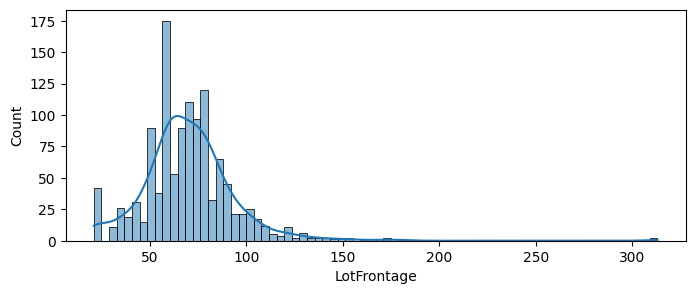

In [128]:
# Check the distribution of the LotFrontage (Linear feet of street connected to property) feature
from scipy.stats import skew
skewness = skew(df['LotFrontage'].dropna())
print(f"Skewness of LotFrontage: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['LotFrontage'].dropna(), kde=True)

Skewness of SalePrice: 1.88


<Axes: xlabel='SalePrice', ylabel='Count'>

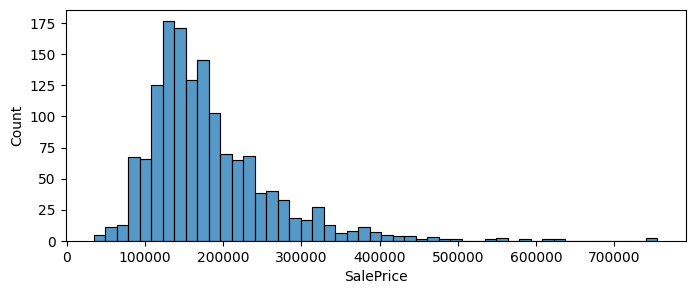

In [129]:
# Check additionaly the distribution of the target variable SalePrice
skewness = skew(df['SalePrice'])
print(f"Skewness of SalePrice: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['SalePrice'])

In [130]:
# The skewness of LotFrontage exceeds 2 which suggests substantial nonnormality. Imputing the mean looks not justified. 
# The skewness of the target feature is as well relatively high. Let's compare its median values for missing and present LotFrontage values to decide on the imputation strategy.

median_missing = df.loc[df['LotFrontage'].isna(), 'SalePrice'].median()
median_present = df.loc[df['LotFrontage'].notna(), 'SalePrice'].median()

print(f"Missing LotFrontage ({df['LotFrontage'].isna().sum()} rows): Median SalePrice: {median_missing:.2f}")
print(f"Present LotFrontage ({df['LotFrontage'].notna().sum()} rows): Median SalePrice: {median_present:.2f}")
print(f"Difference (Missing - Present): {median_missing - median_present:.2f}")

Missing LotFrontage (259 rows): Median SalePrice: 172400.00
Present LotFrontage (1201 rows): Median SalePrice: 159500.00
Difference (Missing - Present): 12900.00


The 12900 median SalePrice difference suggests missingness is informative. Filling with the mean (or even median) of LotFrontage ignores this pattern and could bias the model by assuming missing values behave like present ones, which they don’t (higher median SalePrice).
To account for this factor let's introduce a new binary feature to flag missingness in addition to filling the original column with median values.

In [131]:
df['LotFrontage_missing'] = df['LotFrontage'].isna().astype(int)            # 1 if LotFrontage is missing, 0 otherwise
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())    # impute the median value

Let's now evaluate how the imputation of LotFrontage affected its correlation with SalePrice

In [132]:
# Correlation between LotFrontage (post-imputation) and SalePrice
correlation = df['LotFrontage'].corr(df['SalePrice'])
print(f"Correlation between LotFrontage (post-imputation) and SalePrice: {correlation:.3f}")

# For comparison, compute correlation pre-imputation (on non-missing data)
correlation_pre = df.loc[df['LotFrontage_missing'] == 0, 'LotFrontage'].corr(df.loc[df['LotFrontage_missing'] == 0, 'SalePrice'])
print(f"Correlation between LotFrontage (pre-imputation) and SalePrice: {correlation_pre:.3f}")

Correlation between LotFrontage (post-imputation) and SalePrice: 0.335
Correlation between LotFrontage (pre-imputation) and SalePrice: 0.352


Impact of Imputation:
- The drop from 0.352 to 0.335 is small (~4.8% relative decrease). This suggests that median imputation didn’t significantly distort the relationship between LotFrontage and SalePrice.
- However, even this slight decrease indicates that the imputation introduced a bit of noise. The 259 imputed values (17.7% of the data) are all set to the median, which reduces the variability in LotFrontage and slightly weakens its linear relationship with SalePrice.

- As an alternative we can try to implement regression imputation to predict missing LotFrontage values using other features correlated with them. 
- This might better preserve the relationship with SalePrice by imputing values that reflect patterns in the data.
- Then we will compare which approach turns to be more efficient.
- For this purpose let's first extract a few numerical features which show the strongest association with LotFrontage.

In [133]:
# Select numerical features and compute the correlation matrix
corr_matrix = df.select_dtypes(include='number').corr().round(3)

# Extract correlations involving LotFrontage and sort
lotfrontage_corrs = corr_matrix['LotFrontage'].sort_values()

# Filter correlations: keep only those < -0.3 or > 0.3
filtered_corrs = lotfrontage_corrs[(lotfrontage_corrs < -0.3) | (lotfrontage_corrs > 0.3)].drop('LotFrontage')

# Display the result
print("Correlations between LotFrontage and numerical features (<-0.3 or >0.3):")
print(filtered_corrs)

Correlations between LotFrontage and numerical features (<-0.3 or >0.3):
MSSubClass     -0.357
LotArea         0.305
TotRmsAbvGrd    0.321
GarageArea      0.324
SalePrice       0.335
TotalBsmtSF     0.363
GrLivArea       0.368
1stFlrSF        0.414
Name: LotFrontage, dtype: float64


In [134]:
# Select features for prediction
features = filtered_corrs.index.tolist()

# Split data
train_data = df[df['LotFrontage_missing'] == 0]
test_data = df[df['LotFrontage_missing'] == 1]

# Fit model
model = LinearRegression()
model.fit(train_data[features], train_data['LotFrontage'])

# Predict missing values. Assign the predicted values to the missing LotFrontage entries in the original DataFrame
df.loc[df['LotFrontage_missing'] == 1, 'LotFrontage'] = model.predict(test_data[features])

Now let's recheck the correlation to see if it improves

In [135]:
# Correlation between LotFrontage (post-imputation) and SalePrice
correlation = df['LotFrontage'].corr(df['SalePrice'])
print(f"Correlation between LotFrontage (post-imputation) and SalePrice: {correlation:.3f}")

# For comparison, compute correlation pre-imputation (on non-missing data)
correlation_pre = df.loc[df['LotFrontage_missing'] == 0, 'LotFrontage'].corr(
    df.loc[df['LotFrontage_missing'] == 0, 'SalePrice']
)
print(f"Correlation between LotFrontage (pre-imputation) and SalePrice: {correlation_pre:.3f}")

Correlation between LotFrontage (post-imputation) and SalePrice: 0.366
Correlation between LotFrontage (pre-imputation) and SalePrice: 0.352


- The correlation with SalePrice improved (regression imputation vs median imputation: 0.368 vs. 0.335), indicating that LotFrontage is now a stronger predictor of SalePrice.
- Unlike median imputation, which weakened the relationship, regression imputation strengthened it, suggesting that the imputed values are more representative of the true underlying LotFrontage values.

Now let's explore the next numeric variable win 8 NaNs: MasVnrArea (Masonry veneer area in square feet)

<Axes: xlabel='MasVnrArea', ylabel='Count'>

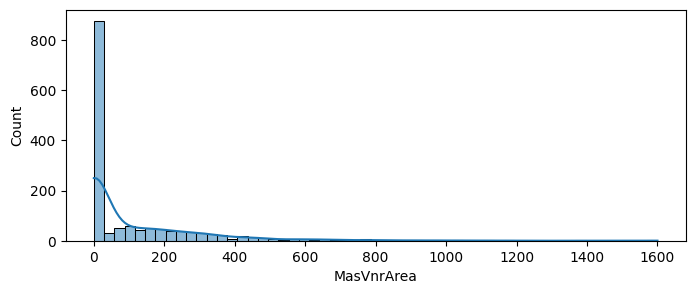

In [136]:
plt.figure(figsize=(8, 3))
sns.histplot(df['MasVnrArea'].dropna(), kde=True)

- There are a lot of zero values which correspond to absence of masonry veneer in certain houses. We just need to make sure that 8 missing values also belong to houses without masonry veneer.
- In the dataset there is a categorical feature MasVnrType which signifies which type of masonry veneer was used. 
- If in the corresponding rows there are no values, this would indicate that 8 missing values comply with the above-mentioned requirement.

In [137]:
df.loc[df['MasVnrArea'].isna(), 'MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [138]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())       # fill NaNs with median which is equal 0
df['MasVnrArea'].isnull().sum()                                             # check if NaNs are filled

# The 0 values in MasVnrArea are not missing values but rather indicate that there is no masonry veneer.
# In the dataset there is already the categorical feature MasVnrType where absent veneer is indicated by the value None.
# So we already have a feature indicating the absence of masonry veneer. No need to create new one based on null values in MasVnrArea.

np.int64(0)

Let's check the last numerical feature containing 81 NaNs: GarageYrBlt (Year garage was built)

<Axes: xlabel='GarageYrBlt', ylabel='Count'>

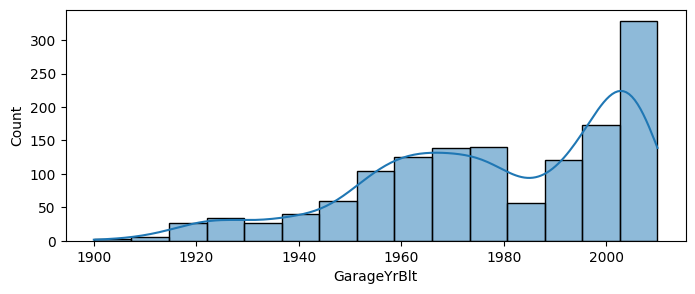

In [139]:
plt.figure(figsize=(8, 3))
sns.histplot(df['GarageYrBlt'].dropna(), kde=True)

In [140]:
# This feature has relatively hight number of NaNs and is likely to be strongly correlated with another feature (YearBuilt) which has no NaNs
# Let's check the correlation between GarageYrBlt and YearBuilt
corr = df.GarageYrBlt.corr(df["YearBuilt"])
print(f"Correlation between GarageYrBlt and YearBuilt: {corr:.3f}")

Correlation between GarageYrBlt and YearBuilt: 0.826


In [141]:
# The correlation is fairly strong -> danger of multicollinearity
# It seems justified to drop GarageYrBlt as YearBuilt must be enough to generally cover the relevant to the house age info
df = df.drop(['GarageYrBlt'], axis=1)

### Let's now deal with categorical features containing NaNs

In [142]:
cols_obj_null_count = df.select_dtypes(include='object').isnull().sum()                             # count NaNs in categorical columns
cols_obj_with_nulls = df.select_dtypes(include='object').columns[cols_obj_null_count > 0].tolist()  # list of categorical features with NaNs
df[cols_obj_with_nulls].select_dtypes(include=['object']).describe(include='all').round(2)          # describe features to better understand their quality and granularity

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
count,91,588,1423,1423,1422,1423,1422,1459,770,1379,1379,1379,1379,7,281,54
unique,2,3,4,4,4,6,6,5,5,6,3,5,5,3,4,4
top,Grvl,BrkFace,TA,TA,No,Unf,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
freq,50,445,649,1311,953,430,1256,1334,380,870,605,1311,1326,3,157,49


In [143]:
obj_with_nulls = df.select_dtypes(include=['object']).isnull().sum()    # count null values in remaining 'object' features
print(obj_with_nulls[obj_with_nulls > 0])                               # filter columns with null values

Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


### Alley (1369 NaNs)

Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64


<Axes: xlabel='Alley', ylabel='SalePrice'>

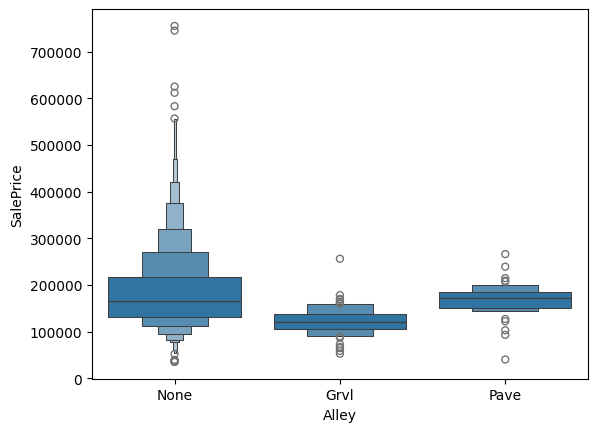

In [144]:
print(df['Alley'].value_counts(dropna=False))       # check the distribution of the Alley (Type of alley access to property: Gravel, Paved and NaN) feature
df['Alley'] = df['Alley'].fillna('None')            # fill nulls with 'None' (no alley access)
sns.boxenplot(x='Alley', y='SalePrice', data=df)    # check the distribution of SalePrice by Alley type

In [145]:
# The visually significant differences in the target justify keeping all features and distinguishing between Grvl and Pave and NoAlley.
# Use target encoding with the median SalePrice. This preserves the signal from all three categories (NoAlley, Grvl, Pave) while handling the rare categories effectively
alley_medians = df.groupby('Alley')['SalePrice'].median()
df['Alley'] = df['Alley'].map(alley_medians)
print("Median SalePrice by Alley:")
print(alley_medians)

Median SalePrice by Alley:
Alley
Grvl    119500.0
None    165000.0
Pave    172500.0
Name: SalePrice, dtype: float64


### MasVnrType (872 NaNs)

In [146]:
# Replace NaN with "None"
df['MasVnrType'] = df['MasVnrType'].fillna('None')
# Check the frequency distribution of the MasVnrType (Masonry veneer type: Brick Face, Stone, Cinder Block, None) feature
df['MasVnrType'].value_counts(dropna=False)       

MasVnrType
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [147]:
# Given the rare category BrkCmn (only 15 instances), target encoding (replacing each category with the median SalePrice for that category) seems like a good choice. 
# It handles rare categories well and keeps the feature as a single column.
masvnr_medians = df.groupby('MasVnrType')['SalePrice'].median()
df['MasVnrType'] = df['MasVnrType'].map(masvnr_medians)
print("Median SalePrice by MasVnrType:")
print(masvnr_medians)

Median SalePrice by MasVnrType:
MasVnrType
BrkCmn     139000.0
BrkFace    181000.0
None       143125.0
Stone      246839.0
Name: SalePrice, dtype: float64


### Bsmt... features (37-38 NaNs)

- BsmtQual (Evaluates the height of the basement), 
- BsmtCond (Evaluates the general condition of the basement), 
- BsmtExposure (Refers to walkout or garden level walls), 
- BsmtFinType1 (Rating of basement finished area), 
- BsmtFinType2 (Rating of basement finished area (if multiple types))

In [148]:
# Select columns that contains "bsmt" in their names
bsmt_cat_features = [col for col in df.columns if 'bsmt' in col.lower() and df[col].dtype == 'object']              # create a list of categorical features
bsmt_num_features = [col for col in df.columns if 'bsmt' in col.lower() and df[col].dtype in ['int64', 'float64']]  # for a reference create a list of numerical features as well
print(f"Categorical basement related features: {bsmt_cat_features}")
print(f"Numerical basement related features: {bsmt_num_features}")

Categorical basement related features: ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Numerical basement related features: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']


Let's first check whether the missed categorical values correspond to some numerical ones. If there are zeroes this would most likely indicate that missing categorical values imply no basement at all.

In [149]:
# Dictionary to store results
results = {}

# Loop through each categorical feature
for feature in bsmt_cat_features:
    # Group by the categorical feature and calculate the mean of numeric features
    group_means = df.groupby(feature, dropna=False)[bsmt_num_features].mean()   # Use dropna=False to include NA as a category
    results[feature] = group_means                                              # Store the results in the dictionary

# Display the results for each categorical feature
for feature, means in results.items():
    print(f"\nMean of numeric features grouped by {feature}:")
    print(means.round(2))
    print("-" * 50)


Mean of numeric features grouped by BsmtQual:
          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtQual                                                                 
Ex            855.33       23.56     766.71      1645.60          0.68   
Fa            130.71        7.89     594.43       733.03          0.17   
Gd            472.50       34.66     623.91      1131.07          0.48   
TA            381.57       66.90     506.96       955.43          0.37   
NaN             0.00        0.00       0.00         0.00          0.00   

          BsmtHalfBath  
BsmtQual                
Ex                0.05  
Fa                0.06  
Gd                0.04  
TA                0.08  
NaN               0.00  
--------------------------------------------------

Mean of numeric features grouped by BsmtCond:
          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtCond                                                                 
Fa           

- For all categorical features (BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2), when the value is NaN, the numerical features are mostly 0, except for small values in BsmtExposure and BsmtFinType2 (e.g., BsmtUnfSF = 24.63 for BsmtExposure = NaN).
- This strongly suggests that NaN means "No Basement," and the small non-zero values might be data inconsistencies (e.g., a small unfinished area recorded but no basement quality specified).
- Given the small proportion of missing values and the discovered relationship with numerical features let's just replace NaNs with 'NA'. This would allows the model to treat it as a valid category meaning "No Basement".

In [150]:
# Replace NaN with "NA"
for feature in bsmt_cat_features:
    df[feature] = df[feature].fillna('NA')

# Verify no more missing values
print("Missing values after replacement:")
print(df[bsmt_cat_features].isnull().sum())

Missing values after replacement:
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64


- Now we need to encode them into a numerical format for modeling. Options include ordinal encoding (if the categories have a natural order), one-hot encoding, or target encoding.
- Ordinal encoding could be a possibility but can be somewhat subjective.
- One-hot-encoding would create a lot of dummies which would expand the model dimensionality too much.
- The best choice can be again target-encoding which implies replacing each subcategory with the median (the target has rather skewed distribution) SalePrice for it. This captures the relationship with the target directly, keeps each feature as a single column, and handles rare categories well (e.g., Po in BsmtCond has few instances).

In [151]:
# Target encode each categorical feature using median SalePrice
for feature in bsmt_cat_features:
    medians = df.groupby(feature)['SalePrice'].median()     # Compute median SalePrice for each category
    df[feature] = df[feature].map(medians)                  # Map the medians to the feature values

In [152]:
# Check the resulting formerly categorical (now numerical) Basement-related features
df[bsmt_cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtQual      1460 non-null   float64
 1   BsmtCond      1460 non-null   float64
 2   BsmtExposure  1460 non-null   float64
 3   BsmtFinType1  1460 non-null   float64
 4   BsmtFinType2  1460 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB


In [153]:
# Check the resulting numerical Basement-related features
df[bsmt_num_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   BsmtFinSF1    1460 non-null   int64
 1   BsmtFinSF2    1460 non-null   int64
 2   BsmtUnfSF     1460 non-null   int64
 3   TotalBsmtSF   1460 non-null   int64
 4   BsmtFullBath  1460 non-null   int64
 5   BsmtHalfBath  1460 non-null   int64
dtypes: int64(6)
memory usage: 68.6 KB


### Electrical feature (1 NaN)

In [154]:
# Check the distribution of the Electrical (Electrical system: SBrkr, FuseA, FuseF, FuseP, Mix) feature
df['Electrical'].value_counts(dropna=False)      

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: count, dtype: int64

Given that SBrkr is the overwhelming majority (>90%), the most likely value for the missing entry is SBrkr.

In [155]:
# Impute NaN with the mode
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# Verify no missing values remain
print("Missing values after imputation:")
print(df['Electrical'].isnull().sum())

Missing values after imputation:
0


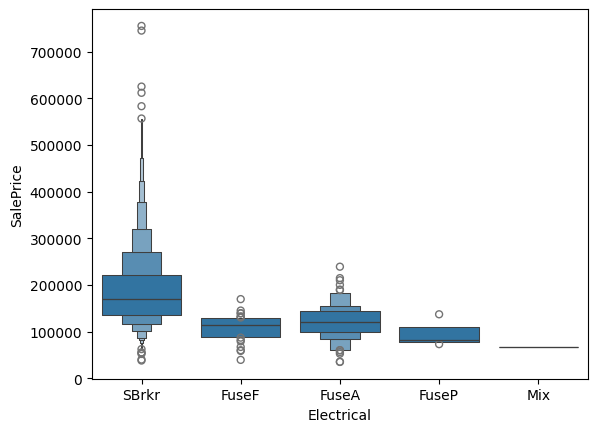

In [156]:
# Check the distribution of SalePrice by Electrical type
sns.boxenplot(x='Electrical', y='SalePrice', data=df)    # Check the distribution of SalePrice by Electrical type
plt.show()

Taking into consideration that SBrkr is the modern standard (circuit breakers), while FuseA, FuseF, and FuseP indicate older fuse box systems with varying capacities and wiring types (Mix indicates a combination of systems) and that there is a clear differentiation between SBrkr and others by SalePrice, it seems reasonable to transform the feature to a binary type.

In [157]:
# Create a binary feature: 1 for SBrkr, 0 for others
df['Electrical'] = (df['Electrical'] == 'SBrkr').astype(int)

# Check the distribution
print(df['Electrical'].value_counts())

Electrical
1    1335
0     125
Name: count, dtype: int64


### FireplaceQu (690 NaNs)

In [158]:
df.FireplaceQu.value_counts(dropna=False)       # check the distribution of the FireplaceQu (Fireplace quality: Ex, Gd, TA, Fa, Po, NA) feature

FireplaceQu
NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: count, dtype: int64

- NaN: 690 (47.3%) – Likely means "No Fireplace"
- Gd (Good): 380 (26.0%)
- TA (Average): 313 (21.4%)
- Fa (Fair): 33 (2.3%)
- Ex Excellent): 24 (1.6%)
- Po (Poor): 20 (1.4%)

In [159]:
# Replace NaN with 'NA' (no fireplace)
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')

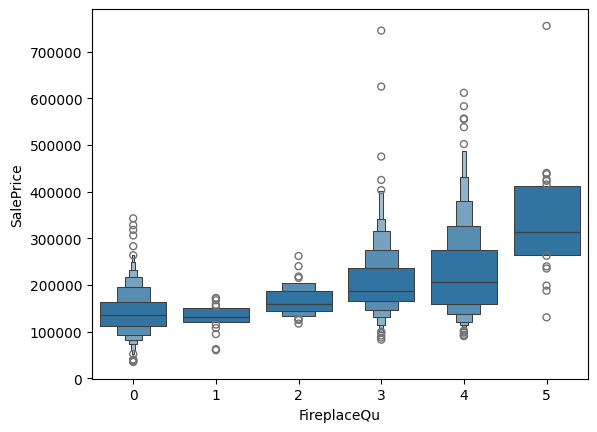

In [160]:
# The feature has a clear ordinal nature. Let's define the order of the categories
ordinal_mapping = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['FireplaceQu'] = df['FireplaceQu'].map(ordinal_mapping)    # Map the ordinal values to the feature

sns.boxenplot(x='FireplaceQu', y='SalePrice', data=df)    # Check the distribution of SalePrice by FireplaceQu type
plt.show()

# Looks good! Almost each following category has a higher median SalePrice than the previous one.

### GarageType, GarageFinish, GarageQual, GarageCond (81 NaNs each)

In [161]:
garage_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] # list of categorical features
df[garage_features].describe(include='all')    # describe features to better understand their quality and granularity

,GarageType,GarageFinish,GarageQual,GarageCond
count,1379,1379,1379,1379
unique,6,3,5,5
top,Attchd,Unf,TA,TA
freq,870,605,1311,1326


In [162]:
# Check another Garage-related feature (with no NaNs) to explore the pattern of missing values
df.GarageArea[df.GarageArea == 0].count()    # count the number of 0 values in GarageArea
print(f"GarageArea has {df.GarageArea[df.GarageArea == 0].count()} rows with 0 values")

GarageArea has 81 rows with 0 values


In [163]:
# It is now clear that missing values correspond to the absence of a garage.
# Impute NaNs with 'NA' (no garage)
for feature in garage_features: 
    df[feature] = df[feature].fillna('NA')

In [164]:
# Check 'GarageType' distribution
df['GarageType'].value_counts()

GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

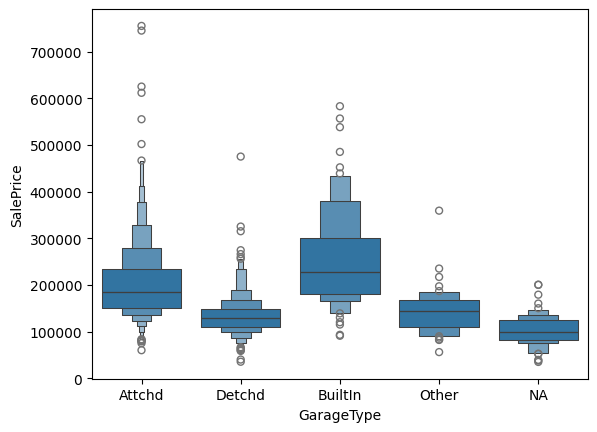

In [165]:
# Due to some very rare subcategories let's combine Basment (19), CarPort (9), 2Types (6) into "Other"
df['GarageType'] = df['GarageType'].replace({'Basment': 'Other', 'CarPort': 'Other', '2Types': 'Other'})
sns.boxenplot(x='GarageType', y='SalePrice', data=df)    # Check the distribution of SalePrice by GarageType type
plt.show()

In [166]:
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
medians = df.groupby('GarageType')['SalePrice'].median()     # Compute median SalePrice for each category
df['GarageType'] = df['GarageType'].map(medians)             # Map the medians to the feature values

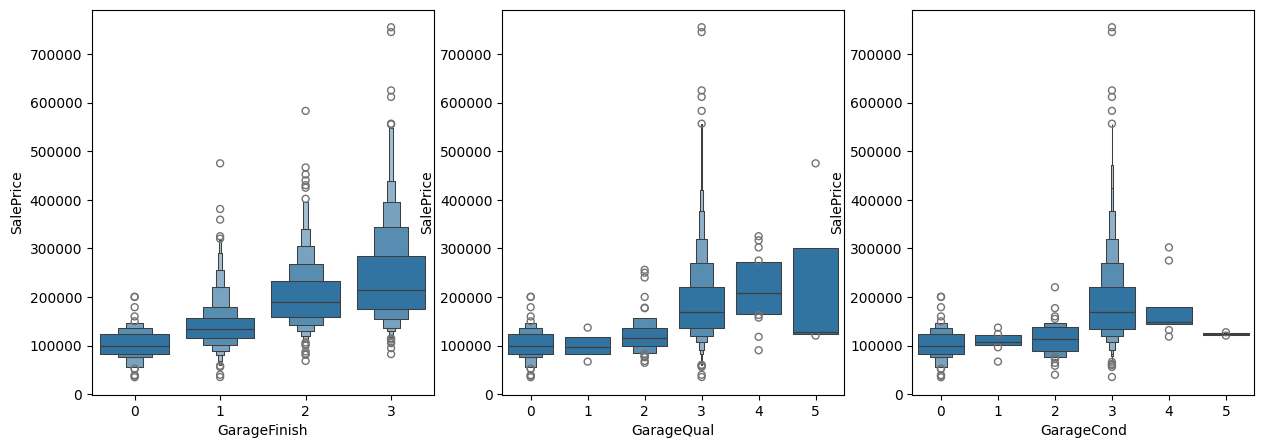

In [167]:
# 'GarageFinish', 'GarageQual', 'GarageCond' are ordinal features. Let's define the order of the categories

# For GarageFinish the sequence is: NA < Unf < RFn < Fin:
ordinal_mapping1 = {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
df['GarageFinish'] = df['GarageFinish'].map(ordinal_mapping1)    # Map the ordinal values to the feature

# For GarageQual and GarageCond the sequence is the same as for FireplaceQu:
ordinal_mapping2 = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['GarageQual'] = df['GarageQual'].map(ordinal_mapping2)    # Map the ordinal values to the feature
df['GarageCond'] = df['GarageCond'].map(ordinal_mapping2)    # Map the ordinal values to the feature

# Check the distribution of SalePrice by ordinal Garage-related features
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.boxenplot(x='GarageFinish', y='SalePrice', data=df, ax=ax1)    
sns.boxenplot(x='GarageQual', y='SalePrice', data=df, ax=ax2)    
sns.boxenplot(x='GarageCond', y='SalePrice', data=df, ax=ax3)    
plt.show()

### PoolQC (1453 NaNs)


In [168]:
# check the distribution of the PoolQC (Pool quality: Ex, Gd, TA, Fa, NA) feature
df.PoolQC.value_counts(dropna=False)

PoolQC
NaN    1453
Gd        3
Ex        2
Fa        2
Name: count, dtype: int64

In [169]:
# Missing values are massive. Let's check another associated with PoolQC numeric feature: PoolArea
df.PoolArea[df.PoolArea == 0].count()    # count the number of 0 values in PoolArea

np.int64(1453)

The prognostic power of both features is extremely small. It seems justified to drop them off.

In [170]:
df = df.drop(['PoolQC', 'PoolArea'], axis=1)    # drop PoolQC and PoolArea as completely uninformative

### Fence (1179 NaNs)

In [171]:
df.Fence.value_counts(dropna=False) # check the distribution of the Fence (Fence quality: GdWo, MnPrv, GdPrv, NA) feature

"""
GdPrv:	Good Privacy
MnPrv:	Minimum Privacy
GdWo:	Good Wood
MnWw:	Minimum Wood/Wire
NA:	    No Fence
"""

'\nGdPrv:\tGood Privacy\nMnPrv:\tMinimum Privacy\nGdWo:\tGood Wood\nMnWw:\tMinimum Wood/Wire\nNA:\t    No Fence\n'

<Axes: xlabel='Fence', ylabel='SalePrice'>

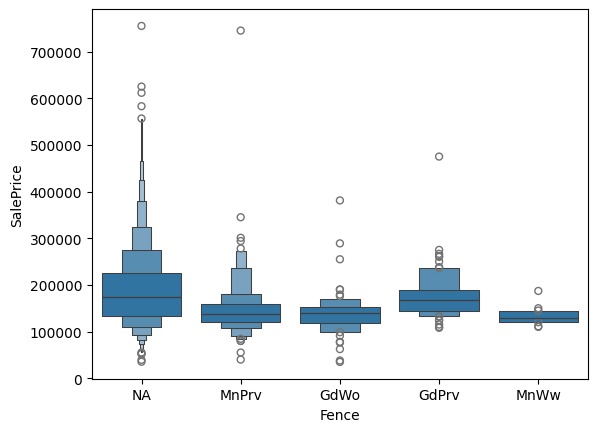

In [172]:
# It is clear that NaNs correspond to the absence of a fence
# Impute NaNs with 'NA' (no fence)
df['Fence'] = df['Fence'].fillna('NA')
sns.boxenplot(x='Fence', y='SalePrice', data=df)    # Check the distribution of SalePrice by Fence type

- The number of missing values is very high. Among rare features only GdPrv (Fence with good privacy) seems to be associated with higher SalesPrice.
- On the other hand, it look no much different from the very large group of "No Fence".
- It seems justified to drop this feature from the model.

In [173]:
df = df.drop(['Fence'], axis=1)    # drop Fence as completely uninformative

### MiscFeature (1406 NaNs)

In [174]:
df.MiscFeature.value_counts(dropna=False) # check the distribution of the MiscFeature (Miscellaneous feature: Tenis Court, Shed, NA) feature

"""
Elev	Elevator
Gar2	2nd Garage (if not described in garage section)
Othr	Other
Shed	Shed (over 100 SF)
TenC	Tennis Court
NA	None
"""

'\nElev\tElevator\nGar2\t2nd Garage (if not described in garage section)\nOthr\tOther\nShed\tShed (over 100 SF)\nTenC\tTennis Court\nNA\tNone\n'

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

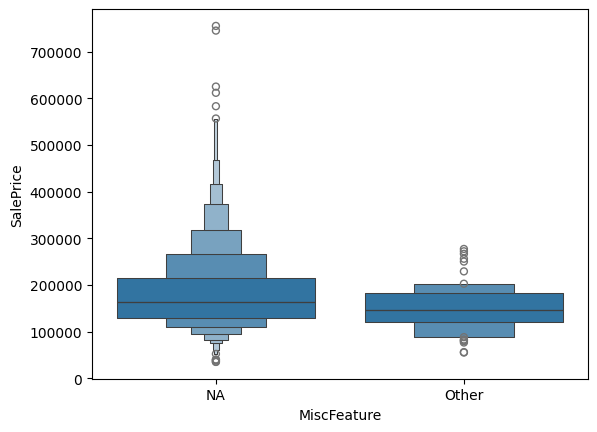

In [175]:
# It is reasonable to join all subcategories into "Other" and impute NaNs with 'NA' (no miscellaneous feature)
df['MiscFeature'] = df['MiscFeature'].replace({'Elev': 'Other', 'Gar2': 'Other', 'Othr': 'Other', 'Shed': 'Other', 'TenC': 'Other'})
df['MiscFeature'] = df['MiscFeature'].fillna('NA')    # fill NaNs with 'NA' (no miscellaneous feature)
sns.boxenplot(x='MiscFeature', y='SalePrice', data=df)    # Check the distribution of SalePrice by MiscFeature type

In [176]:
df_na_count = df.isnull().sum()    # check if there are any missing values left in the dataset
print(f"Missing values in the dataset:\n{df_na_count[df_na_count > 0]}")    # filter columns with NaNs

Missing values in the dataset:
Series([], dtype: int64)



---

## **2. Exploratory Data Analysis (EDA)**

### Question 3: Describe the dataset's numerical features.
- Use `describe()` to get a summary of the dataset's numerical columns.
- Which feature(s) have the highest and lowest values? Are there any surprising observations?

In [177]:
df.select_dtypes(include='number').describe().round(2)    # check the basic descriptive statistics for numerical features

,Id,MSSubClass,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,LotFrontage_missing
count,1460.00,1460.0,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,...,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0,1460.00
mean,730.50,56.9,70.57,10516.83,163652.40,6.10,5.58,1971.27,1984.87,163719.45,...,94.24,46.66,21.95,3.41,15.06,43.49,6.32,2007.82,180921.2,0.18
std,421.61,42.3,23.30,9981.26,8408.98,1.38,1.11,30.20,20.65,30935.02,...,125.34,66.26,61.12,29.32,55.76,496.12,2.70,1.33,79442.5,0.38
min,1.00,20.0,21.00,1300.00,119500.00,1.00,1.00,1872.00,1950.00,139000.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.0,0.00
25%,365.75,20.0,60.00,7553.50,165000.00,5.00,5.00,1954.00,1967.00,143125.00,...,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.0,0.00
50%,730.50,50.0,70.00,9478.50,165000.00,6.00,5.00,1973.00,1994.00,143125.00,...,0.00,25.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.0,0.00
75%,1095.25,70.0,80.00,11601.50,165000.00,7.00,6.00,2000.00,2004.00,181000.00,...,168.00,68.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.0,0.00
max,1460.00,190.0,313.00,215245.00,172500.00,10.00,9.00,2010.00,2010.00,246839.00,...,857.00,547.00,552.00,508.00,480.00,15500.00,12.00,2010.00,755000.0,1.00


In [178]:
df = df.drop('Id', axis=1)    # drop the Id column as it is not informative for prediction
df_num_features = df.select_dtypes(include='number').columns.tolist()    # list of left numerical features
print(f"At the moment we have {len(df_num_features)} numerical features in the dataframe out of {df.shape[1]} total features")

At the moment we have 49 numerical features in the dataframe out of 77 total features


The number of numeric features is large. Many features have very different magnitudes of variability. Some have very different from normal distributions.

### Question 4: Visualize the distribution of house prices.
- Create a histogram of the house prices. Is the distribution normal or skewed?

Skewness of SalePrice: 1.88


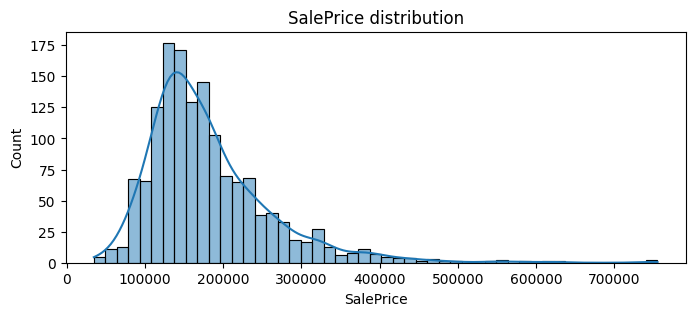

In [179]:
# Check the skewness and distribution of the target variable SalePrice
skewness = skew(df['SalePrice'])
print(f"Skewness of SalePrice: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.show()

The target's distribution is mostly right-skewed, with a long tail on right side, indicating that there are a few cases of very expensive houses in the dataset.


### Question 5: Explore relationships between features and house prices.
- Create scatter plots for at least 3 features vs. house prices (target variable).
- What relationships do you observe between the selected features and the target?


In [180]:
corr_matrix = df.select_dtypes(include='number').corr().round(3)        # Select numerical features and compute the correlation matrix
corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10)    # Extract strongest correlations with SalePrice and sort by absolute value

SalePrice       1.000
OverallQual     0.791
GrLivArea       0.709
BsmtQual        0.681
GarageCars      0.640
GarageArea      0.623
TotalBsmtSF     0.614
1stFlrSF        0.606
FullBath        0.561
GarageFinish    0.549
Name: SalePrice, dtype: float64

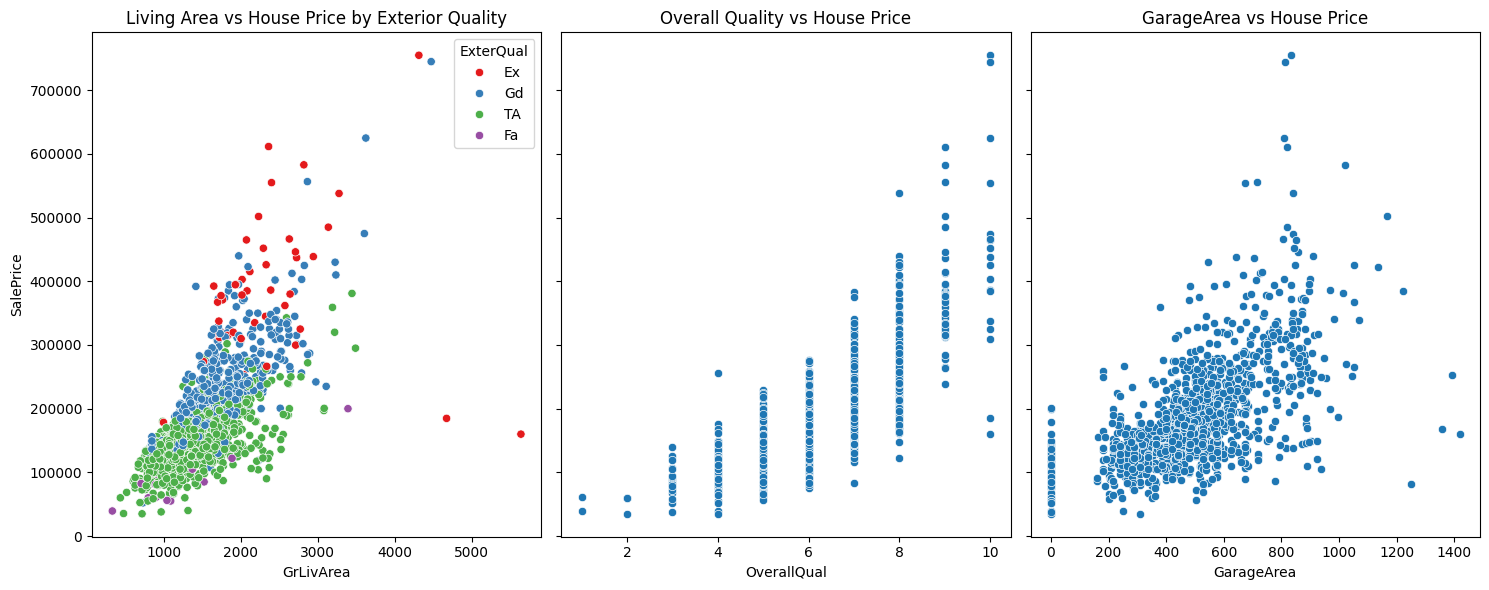

In [181]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

exterqual_order = ['Ex', 'Gd', 'TA', 'Fa']

sns.scatterplot(df, x='GrLivArea', y='SalePrice', hue='ExterQual', hue_order=exterqual_order, palette='Set1', ax=ax1)    
ax1.set_title('Living Area vs House Price by Exterior Quality')
sns.scatterplot(df, x='OverallQual', y='SalePrice', ax=ax2)
ax2.set_title('Overall Quality vs House Price')
ax2.set_ylabel('')
ax2.set_yticklabels([])
sns.scatterplot(df, x='GarageArea', y='SalePrice', ax=ax3)
ax3.set_title('GarageArea vs House Price')
ax3.set_ylabel('')
ax3.set_yticklabels([])
plt.tight_layout()
plt.show()


The depicted scatterplots represent relatively strong positive correlations between house selling price and such variables as Living Area (moderated by Exterior Quality), Overall Quality of the house and Garage Area. They must have the strongest predictive power for our model.


---

## **3. Feature Selection**

### Question 6: Correlation Analysis
- Calculate the correlation matrix of the dataset.
- Based on the correlation, identify at least 2 features that are highly correlated with house prices.
- Are there any features that are strongly correlated with each other but not with the target?


In [182]:
df.select_dtypes(include='object').describe(include='all').round(2)    # describe not yet processed categorical features to better understand their granularity
                                                                       # we need to convert them to numerical features as well

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,6,6,5,2,4,7,3,2,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,PConc,GasA,Ex,Y,TA,Typ,Y,NA,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,647,1428,741,1365,735,1360,1340,1406,1267,1198


In [183]:
# Divide categorical features for convenience into three groups based on the number of unique values
obj_features = df.select_dtypes(include='object').columns.tolist()                  # list of categorical features
obj_2_features = [col for col in obj_features if df[col].nunique() ==2]             # list of categorical features with only two categories
obj_3_5_features = [col for col in obj_features if 3 <= df[col].nunique() <= 5]     # list of categorical features with 3 to 5 categories
obj_6_plus_features = [col for col in obj_features if df[col].nunique() > 5]        # list of categorical features with 6 or more categories

In [184]:
# Check the distribution of unique values in categorical features with only two subcategories
for col in obj_2_features:
    print(f"Distribution of unique values in {col}:")
    for category, count in df[col].value_counts().items():
        print(f"{category:<8} {count}")
    print()

Distribution of unique values in Street:
Pave     1454
Grvl     6

Distribution of unique values in Utilities:
AllPub   1459
NoSeWa   1

Distribution of unique values in CentralAir:
Y        1365
N        95

Distribution of unique values in MiscFeature:
NA       1406
Other    54



In [185]:
# Street and Utilities have very low differentiation power. Drop them
df = df.drop(['Street', 'Utilities'], axis=1)

# CentralAir and MiscFeature are good to go. Convert them to 1/0
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})           # Convert CentralAir to 1/0
df['MiscFeature'] = df['MiscFeature'].map({'NA': 0, 'Other': 1})    # Convert MiscFeature to 1/0

In [186]:
# Check the distribution of unique values in categorical features with 3 to 5 subcategories
for col in obj_3_5_features:
    print(f"Distribution of unique values in {col}:")
    for category, count in df[col].value_counts().items():
        print(f"{category:<8} {count}")
    print()

Distribution of unique values in MSZoning:
RL       1151
RM       218
FV       65
RH       16
C (all)  10

Distribution of unique values in LotShape:
Reg      925
IR1      484
IR2      41
IR3      10

Distribution of unique values in LandContour:
Lvl      1311
Bnk      63
HLS      50
Low      36

Distribution of unique values in LotConfig:
Inside   1052
Corner   263
CulDSac  94
FR2      47
FR3      4

Distribution of unique values in LandSlope:
Gtl      1382
Mod      65
Sev      13

Distribution of unique values in BldgType:
1Fam     1220
TwnhsE   114
Duplex   52
Twnhs    43
2fmCon   31

Distribution of unique values in ExterQual:
TA       906
Gd       488
Ex       52
Fa       14

Distribution of unique values in ExterCond:
TA       1282
Gd       146
Fa       28
Ex       3
Po       1

Distribution of unique values in HeatingQC:
Ex       741
TA       428
Gd       241
Fa       49
Po       1

Distribution of unique values in KitchenQual:
TA       735
Gd       586
Ex       100
Fa       39


In [187]:
# MSZoning has two very rare categories. Let's combine them into "Other" and use target encoding (median SalePrice per category) to capture the relationship with SalePrice
df['MSZoning'] = df['MSZoning'].replace({'C (all)': 'Other', 'RH': 'Other'})    # Combine rare categories into "Other"
mszoning_medians = df.groupby('MSZoning')['SalePrice'].median()                 # Compute median SalePrice for each category
df['MSZoning'] = df['MSZoning'].map(mszoning_medians)                           # Map the medians to the feature values
print(f"The number of resulting numerized categories in MSZoning: {df['MSZoning'].nunique()}")

The number of resulting numerized categories in MSZoning: 4


In [188]:
# LotShape: IR3 is very rare. Let's combine it with IR2 and use target encoding (median SalePrice per category) to capture the relationship with SalePrice
df['LotShape'] = df['LotShape'].replace({'IR3': 'IR2'})                         # Combine rare categories into "IR2"
lotshape_medians = df.groupby('LotShape')['SalePrice'].median()                 # Compute median SalePrice for each category
df['LotShape'] = df['LotShape'].map(lotshape_medians)                           # Map the medians to the feature values
print(f"The number of resulting numerized categories in LotShape: {df['LotShape'].nunique()}")

The number of resulting numerized categories in LotShape: 3


In [189]:
# LandContour: No extremely rare subcategories, no need to combine categories. 
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
landcontour_medians = df.groupby('LandContour')['SalePrice'].median()           # Compute median SalePrice for each category
df['LandContour'] = df['LandContour'].map(landcontour_medians)                  # Map the medians to the feature values

In [190]:
# LotConfig: Fr3 and Fr2 can be combined into "Fr" (Frontage). Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
df['LotConfig'] = df['LotConfig'].replace({'FR3': 'FR', 'FR2': 'FR'})           # Combine rare categories into "Fr"
lotconfig_medians = df.groupby('LotConfig')['SalePrice'].median()               # Compute median SalePrice for each category
df['LotConfig'] = df['LotConfig'].map(lotconfig_medians)                        # Map the medians to the feature values
print(f"The number of resulting numerized categories in LotConfig: {df['LotConfig'].nunique()}")

The number of resulting numerized categories in LotConfig: 4


In [191]:
# LandSlope: Rare category Sev will be combined with Mod. Resulting 2 categories will be 1/0 encoded
df['LandSlope'] = df['LandSlope'].replace({'Sev': 'Mod'})                    # Combine rare categories into "Mod"
landslope_mapping = {'Gtl': 1, 'Mod': 0}                                     # Create mapping for LandSlope
df['LandSlope'] = df['LandSlope'].map(landslope_mapping)                     # Map the mapping to the feature values
print(f"The number of resulting numerized categories in LandSlope: {df['LandSlope'].nunique()}")

The number of resulting numerized categories in LandSlope: 2


In [192]:
# BldgType: Uneven distribution of categories but no extremely rare subcategories
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
bldgtype_medians = df.groupby('BldgType')['SalePrice'].median()               # Compute median SalePrice for each category
df['BldgType'] = df['BldgType'].map(bldgtype_medians)                         # Map the medians to the feature values

In [193]:
# ExterQual: Rare category Fa (Fair) will be combined with TA (Typical/Average)
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
df['ExterQual'] = df['ExterQual'].replace({'Fa': 'TA'})                       # Combine rare categories into "TA"
exterqual_medians = df.groupby('ExterQual')['SalePrice'].median()             # Compute median SalePrice for each category
df['ExterQual'] = df['ExterQual'].map(exterqual_medians)                      # Map the medians to the feature values
print(f"The number of resulting numerized categories in ExterQual: {df['ExterQual'].nunique()}")

The number of resulting numerized categories in ExterQual: 3


In [194]:
# ExterCond: Rare category Po (Poor) will be combined with Fa (Fair). Rare category Ex (Excellent) will be combined with Gd (Good)
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
df['ExterCond'] = df['ExterCond'].replace({'Po': 'Fa', 'Ex': 'Gd'})           # Combine rare categories into "Fa" and "Gd"
extercond_medians = df.groupby('ExterCond')['SalePrice'].median()             # Compute median SalePrice for each category
df['ExterCond'] = df['ExterCond'].map(extercond_medians)                      # Map the medians to the feature values
print(f"The number of resulting numerized categories in ExterCond: {df['ExterCond'].nunique()}")

The number of resulting numerized categories in ExterCond: 3


In [195]:
# HeatingQC: Rare category Po (Poor) will be combined with Fa (Fair).
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
df['HeatingQC'] = df['HeatingQC'].replace({'Po': 'Fa'})                      # Combine rare categories into "Fa"
heatingqc_medians = df.groupby('HeatingQC')['SalePrice'].median()            # Compute median SalePrice for each category
df['HeatingQC'] = df['HeatingQC'].map(heatingqc_medians)                     # Map the medians to the feature values
print(f"The number of resulting numerized categories in HeatingQC: {df['HeatingQC'].nunique()}")

The number of resulting numerized categories in HeatingQC: 4


In [196]:
# KitchenQual: No extremely rare categories, no need to combine them
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
kitchenqual_medians = df.groupby('KitchenQual')['SalePrice'].median()       # Compute median SalePrice for each category
df['KitchenQual'] = df['KitchenQual'].map(kitchenqual_medians)              # Map the medians to the feature values

In [197]:
# PavedDrive: No extremely rare categories, no need to combine them
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
paveddrive_medians = df.groupby('PavedDrive')['SalePrice'].median()        # Compute median SalePrice for each category
df['PavedDrive'] = df['PavedDrive'].map(paveddrive_medians)               # Map the medians to the feature values

In [198]:
df[obj_6_plus_features].nunique()    # check the number of unique values in categorical features with 6 or more subcategories

Neighborhood     25
Condition1        9
Condition2        8
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
Foundation        6
Heating           6
Functional        7
SaleType          9
SaleCondition     6
dtype: int64

In [199]:
df['Neighborhood'].value_counts(dropna=False)    # check the distribution of the Neighborhood (Physical locations within Ames city limits) feature

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

In [200]:
# Combine the rarest categories Blueste, NpkVill and Veenker into "Other"
df['Neighborhood'] = df['Neighborhood'].replace({'Blueste': 'Other', 'NPkVill': 'Other', 'Veenker': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
neighborhood_medians = df.groupby('Neighborhood')['SalePrice'].median()     # Compute median SalePrice for each category
df['Neighborhood'] = df['Neighborhood'].map(neighborhood_medians)           # Map the medians to the feature values
print(f"The number of resulting numerized categories in Neighborhood: {df['Neighborhood'].nunique()}")

The number of resulting numerized categories in Neighborhood: 23


In [201]:
df['Condition1'].value_counts()   # check the distribution of the Condition1 (Proximity to various conditions) feature

Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: count, dtype: int64

In [202]:
# Combine RRNe, RRNn, PosA and RRAe into "Other"
df['Condition1'] = df['Condition1'].replace({'RRNe': 'Other', 'RRNn': 'Other', 'PosA': 'Other', 'RRAe': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
condition1_medians = df.groupby('Condition1')['SalePrice'].median()         # Compute median SalePrice for each category
df['Condition1'] = df['Condition1'].map(condition1_medians)                 # Map the medians to the feature values
print(f"The number of resulting numerized categories in Condition1: {df['Condition1'].nunique()}")

The number of resulting numerized categories in Condition1: 6


In [203]:
df['Condition2'].value_counts()   # check the distribution of the Condition2 (Proximity to various conditions (if not in Condition1)) feature

Condition2
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: count, dtype: int64

In [204]:
# Condition2 seems to be uninformative for a model and will be dropped
df = df.drop(['Condition2'], axis=1)    # drop Condition2 as completely uninformative

In [205]:
df['HouseStyle'].value_counts()   # check the distribution of the HouseStyle (Style of dwelling) feature

HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64

In [206]:
# HouseStyle: three last categories are rare and will be combined into "Other"
df['HouseStyle'] = df['HouseStyle'].replace({'2.5Fin': 'Other', '2.5Unf': 'Other', '1.5Unf': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
housestyle_medians = df.groupby('HouseStyle')['SalePrice'].median()         # Compute median SalePrice for each category
df['HouseStyle'] = df['HouseStyle'].map(housestyle_medians)                 # Map the medians to the feature values
print(f"The number of resulting numerized categories in HouseStyle: {df['HouseStyle'].nunique()}")

The number of resulting numerized categories in HouseStyle: 6


In [207]:
df['RoofStyle'].value_counts()   # check the distribution of the RoofStyle (Type of roof) feature

RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: count, dtype: int64

In [208]:
# RoofStyle: four last categories are rare and will be combined into "Other"
df['RoofStyle'] = df['RoofStyle'].replace({'Shed': 'Other', 'Mansard': 'Other', 'Gambrel': 'Other', 'Flat': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
roofstyle_medians = df.groupby('RoofStyle')['SalePrice'].median()         # Compute median SalePrice for each category
df['RoofStyle'] = df['RoofStyle'].map(roofstyle_medians)                  # Map the medians to the feature values
print(f"The number of resulting numerized categories in RoofStyle: {df['RoofStyle'].nunique()}")

The number of resulting numerized categories in RoofStyle: 3


In [209]:
df['RoofMatl'].value_counts(dropna=False)   # check the distribution of the RoofMatl (Roof material) feature

RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: count, dtype: int64

In [210]:
# RoofMatl: all categories except CompShg are rare and will be combined into "Other"
df['RoofMatl'] = df['RoofMatl'].replace({'Tar&Grv': 'Other', 'WdShngl': 'Other', 'WdShake': 'Other', 'Metal': 'Other', 'Membran': 'Other', 'Roll': 'Other', 'ClyTile': 'Other'})
# Use 1/o encoding for CompShg and Other categories
roofmatl_mapping = {'CompShg': 1, 'Other': 0}                               # Create mapping for RoofMatl
df['RoofMatl'] = df['RoofMatl'].map(roofmatl_mapping)                       # Map the mapping to the feature values
print(f"The number of resulting numerized categories in RoofMatl: {df['RoofMatl'].nunique()}")

The number of resulting numerized categories in RoofMatl: 2


In [211]:
df['Exterior1st'].value_counts()   # check the distribution of the Exterior1st (Exterior covering on house) feature

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64

In [212]:
# Exterior1st: five last categories are rare and will be combined into "Other"
df['Exterior1st'] = df['Exterior1st'].replace({'CBlock': 'Other', 'ImStucc': 'Other', 'AsphShn': 'Other', 'Stone': 'Other', 'BrkComm': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
exterior1st_medians = df.groupby('Exterior1st')['SalePrice'].median()         # Compute median SalePrice for each category
df['Exterior1st'] = df['Exterior1st'].map(exterior1st_medians)                # Map the medians to the feature values
print(f"The number of resulting numerized categories in Exterior1st: {df['Exterior1st'].nunique()}")

The number of resulting numerized categories in Exterior1st: 11


In [213]:
df['Exterior2nd'].value_counts()   # check the distribution of the Exterior2nd (Exterior covering on house) feature

Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: count, dtype: int64

In [214]:
# Exterior2nd: six last categories are rare and will be combined into "Other"
df['Exterior2nd'] = df['Exterior2nd'].replace({'CBlock': 'Other', 'AsphShn': 'Other', 'Stone': 'Other', 'Brk Cmn': 'Other', 'ImStucc': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
exterior2nd_medians = df.groupby('Exterior2nd')['SalePrice'].median()         # Compute median SalePrice for each category
df['Exterior2nd'] = df['Exterior2nd'].map(exterior2nd_medians)                # Map the medians to the feature values
print(f"The number of resulting numerized categories in Exterior2nd: {df['Exterior2nd'].nunique()}")

The number of resulting numerized categories in Exterior2nd: 11


In [215]:
df['Foundation'].value_counts()   # check the distribution of the Foundation (Type of foundation) feature

Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64

In [216]:
# Foundation: two last categories are very rare and will be combined with another relatively rare category Slab
df['Foundation'] = df['Foundation'].replace({'Wood': 'Slab', 'Stone': 'Slab'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
foundation_medians = df.groupby('Foundation')['SalePrice'].median()         # Compute median SalePrice for each category
df['Foundation'] = df['Foundation'].map(foundation_medians)                # Map the medians to the feature values
print(f"The number of resulting numerized categories in Foundation: {df['Foundation'].nunique()}")

The number of resulting numerized categories in Foundation: 4


In [217]:
df['Heating'].value_counts()   # check the distribution of the Heating (Type of heating) feature

Heating
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64

In [218]:
# Heating: all categories except GasA are rare and will be combined into "Other"
df['Heating'] = df['Heating'].replace({'GasW': 'Other', 'Grav': 'Other', 'Wall': 'Other', 'OthW': 'Other', 'Floor': 'Other'})
# Use 1/o encoding for GasA and Other categories
heating_mapping = {'GasA': 1, 'Other': 0}                                # Create mapping for Heating
df['Heating'] = df['Heating'].map(heating_mapping)                       # Map the mapping to the feature values
print(f"The number of resulting numerized categories in Heating: {df['Heating'].nunique()}")

The number of resulting numerized categories in Heating: 2


In [219]:
df['Functional'].value_counts()   # check the distribution of the Functional (Home functionality) feature

Functional
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: count, dtype: int64

In [220]:
# Functional: four last categories are rare and will be combined into "Other"
df['Functional'] = df['Functional'].replace({'Mod': 'Other', 'Maj1': 'Other', 'Maj2': 'Other', 'Sev': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
functional_medians = df.groupby('Functional')['SalePrice'].median()         # Compute median SalePrice for each category
df['Functional'] = df['Functional'].map(functional_medians)                # Map the medians to the feature values
print(f"The number of resulting numerized categories in Functional: {df['Functional'].nunique()}")

The number of resulting numerized categories in Functional: 4


In [221]:
df['SaleType'].value_counts()   # check the distribution of the SaleType (Type of sale) feature

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64

In [222]:
# SaleType: six last categories are rare and will be combined into "Other"
df['SaleType'] = df['SaleType'].replace({'ConLD': 'Other', 'ConLI': 'Other', 'ConLw': 'Other', 'CWD': 'Other', 'Oth': 'Other', 'Con': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
saletype_medians = df.groupby('SaleType')['SalePrice'].median()         # Compute median SalePrice for each category
df['SaleType'] = df['SaleType'].map(saletype_medians)                   # Map the medians to the feature values
print(f"The number of resulting numerized categories in SaleType: {df['SaleType'].nunique()}")

The number of resulting numerized categories in SaleType: 4


In [223]:
df['SaleCondition'].value_counts()   # check the distribution of the SaleCondition (Condition of sale) feature

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

In [224]:
# SaleCondition: two last categories are rare and will be combined into "Other"
df['SaleCondition'] = df['SaleCondition'].replace({'AdjLand': 'Other', 'Alloca': 'Other'})
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
salecnd_medians = df.groupby('SaleCondition')['SalePrice'].median()       # Compute median SalePrice for each category
df['SaleCondition'] = df['SaleCondition'].map(salecnd_medians)            # Map the medians to the feature values
print(f"The number of resulting numerized categories in SaleCondition: {df['SaleCondition'].nunique()}")

The number of resulting numerized categories in SaleCondition: 5


In [225]:
# Control for occasionally left 'object' features
print(df.select_dtypes(include='object').columns)
print(df.shape)

Index([], dtype='object')
(1460, 74)


In [226]:
# Divide the dataframe features into predictive ones and the target
X = df.drop('SalePrice', axis=1).copy()       # Create a copy of the DataFrame without the target variable
y = df['SalePrice']                           # Target variable

As we haven't yet normalized our features let's do it now. But we should avoid normalizing the 1/0 features.

In [227]:
# Identify non-1/0 numerical columns
non_binary_cols = [col for col in X.columns if set(X[col].unique()) != {0, 1}]

# Apply StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Verify the transformation
print(X.head(3))

   MSSubClass  MSZoning  LotFrontage   LotArea     Alley  LotShape  \
0    0.073375  0.349578    -0.239024 -0.207142  0.160312 -0.744139   
1   -0.872563  0.349578     0.405027 -0.091886  0.160312 -0.744139   
2    0.073375  0.349578    -0.110214  0.073480  0.160312  1.175924   

   LandContour  LotConfig  LandSlope  Neighborhood  ...  EnclosedPorch  \
0    -0.133461  -0.287438          1      0.411926  ...      -0.359325   
1    -0.133461   0.259433          1     -0.278065  ...      -0.359325   
2    -0.133461  -0.287438          1      0.411926  ...      -0.359325   

   3SsnPorch  ScreenPorch  MiscFeature   MiscVal    MoSold    YrSold  \
0  -0.116339    -0.270208            0 -0.087688 -1.599111  0.138777   
1  -0.116339    -0.270208            0 -0.087688 -0.489110 -0.614439   
2  -0.116339    -0.270208            0 -0.087688  0.990891  0.138777   

   SaleType  SaleCondition  LotFrontage_missing  
0 -0.263201      -0.175021                    0  
1 -0.263201      -0.175021       

In [228]:
# Create a temporary DataFrame by joining X and y
temp_df = X.copy()
temp_df['y'] = y

# Calculate correlations between y and all features in X
correlations = temp_df.corr()['y'].drop('y')  # drop y's correlation with itself

In [229]:
# Get 20 strongest correlations (by absolute value)
top_20_correlations = correlations.abs().sort_values(ascending=False).head(20)

# Print top 20 correlations with their actual values (not absolute)
print("Top 20 strongest correlations with y:")
print(correlations[top_20_correlations.index])

Top 20 strongest correlations with y:
OverallQual     0.790982
Neighborhood    0.728774
GrLivArea       0.708624
ExterQual       0.686523
BsmtQual        0.681441
KitchenQual     0.674821
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
Foundation      0.502729
GarageType      0.497029
MasVnrArea      0.472614
Fireplaces      0.466929
Name: y, dtype: float64


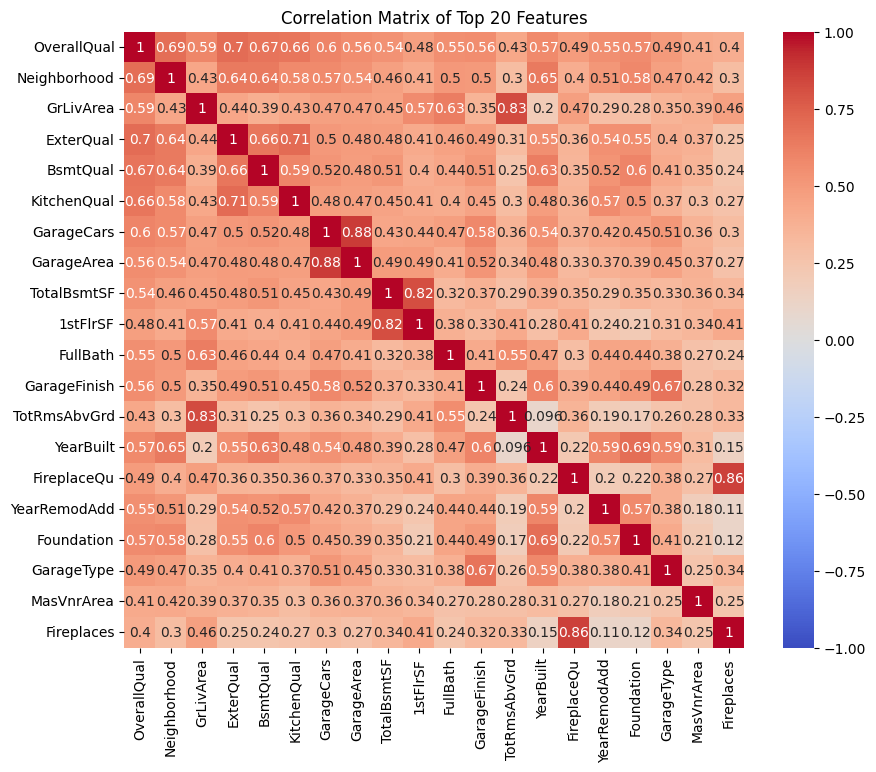

In [230]:
# Get the top 20 features with the strongest correlations with y
top_20_features = correlations.abs().sort_values(ascending=False).head(20).index.tolist()

# Subset X to include only the top 20 features
X_top_20 = X[top_20_features]

# Compute the correlation matrix among these features
correlation_matrix = X_top_20.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of Top 20 Features")
plt.show()

All 20 X-features are positively correlated among themselves but none stronger than r=0.9. In that sense we shouldn't expect critical problems related to multicollinearity


---

## **4. Regression Modeling**


## Train/Validation/Test Split

In [231]:
# Split the data into 60/20/20 using `train_test_split`.

from sklearn.model_selection import train_test_split

X = df.drop(columns='SalePrice')
y = df['SalePrice']

# Your split code here
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
import numpy as np

scaler = StandardScaler()
pipeline = make_pipeline(scaler, LinearRegression())

# Fit model on training data
pipeline.fit(X_train, y_train)

# Predict on training and validation data
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

# Calculate MSE and RMSE for validation data
train_mse = mse(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Calculate MSE and RMSE for validation data
val_mse = mse(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Print results
print(f"Training MSE: {train_mse:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Val MSE: {val_mse:.2f}")
print(f"Val RMSE: {val_rmse:.2f}")

Training MSE: 820726081.80
Training RMSE: 28648.32
Val MSE: 867928225.32
Val RMSE: 29460.62


In [246]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

scaler = StandardScaler()
ridge = make_pipeline(scaler, Ridge(alpha=1.0))  # Use Ridge for regularization

# Fit model on training data
ridge.fit(X_train, y_train)

# Predict on training and validation data
y_train_pred = ridge.predict(X_train)
y_val_pred = ridge.predict(X_val)

# Calculate MSE and RMSE for training data
train_mse = mse(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Calculate MSE and RMSE for validation data
val_mse = mse(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Print results
print(f"\nTraining MSE: {train_mse:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Val MSE: {val_mse:.2f}")
print(f"Val RMSE: {val_rmse:.2f}")


Training MSE: 820737872.70
Training RMSE: 28648.52
Val MSE: 867207691.85
Val RMSE: 29448.39


In [250]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Log-transform the target variable to stabilize variance
y_train_log = np.log1p(y_train)  # log1p handles zero/positive values
y_val_log = np.log1p(y_val)

# Create pipeline with scaling and Ridge regression
pipeline = make_pipeline(
    StandardScaler(),
    Ridge(alpha=0.1)
)

# Fit model on training data (log-transformed target)
pipeline.fit(X_train, y_train_log)

# Predict on training and validation data
y_train_log_pred = pipeline.predict(X_train)
y_val_log_pred = pipeline.predict(X_val)

# Convert predictions back to original scale
y_train_pred = np.expm1(y_train_log_pred)  # expm1 reverses log1p
y_val_pred = np.expm1(y_val_log_pred)

# Calculate MSE and RMSE for training data (original scale)
train_mse = mse(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Calculate MSE and RMSE for test data (original scale)
val_mse = mse(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Cross-validation on log-transformed target
cv_scores = cross_val_score(pipeline, X_train, y_train_log, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())

# Print results
print(f"Training MSE: {train_mse:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Val MSE: {val_mse:.2f}")
print(f"Val RMSE: {val_rmse:.2f}")
print(f"Cross-validated RMSE (log scale): {cv_rmse:.2f}")


Training MSE: 742853505.11
Training RMSE: 27255.34
Val MSE: 705970211.77
Val RMSE: 26570.10
Cross-validated RMSE (log scale): 0.15


Best parameters: {'ridge__alpha': 100.0}
Best CV RMSE (log scale): 0.13125634555698024

Training MSE: 758575048.7867
Training RMSE: 27542.2412
Val MSE: 671361015.4625
Val RMSE: 25910.6352

Outliers in y_val: 178     501837
1169    625000
Name: SalePrice, dtype: int64


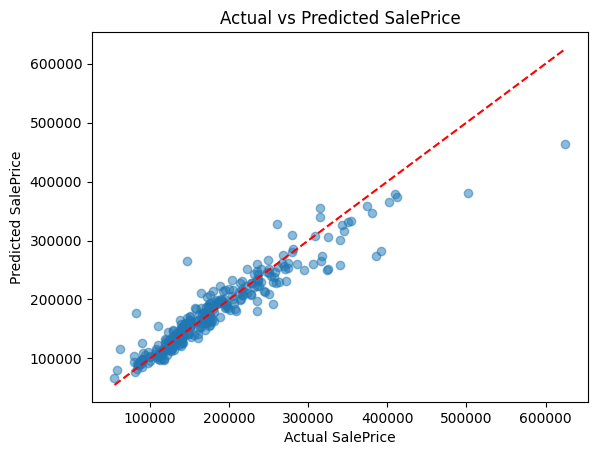


Random Forest Results:
Training MSE: 145704590.0115
Training RMSE: 12070.8156
Val MSE: 822735455.7708
Val RMSE: 28683.3655


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Log-transform skewed numeric features in X_train/X_test
skewed_cols = X_train.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train.copy()
X_val_skewed = X_val.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_val_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_val_skewed[skewed_cols.index[skewed_cols]])

# Log-transform the target variable
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_test)

# Create pipeline
pipeline = make_pipeline(
    StandardScaler(),
    Ridge()
)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'ridge__alpha': [1.0, 10.0, 100.0]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_skewed, y_train_log)

# Best model
best_pipeline = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE (log scale):", np.sqrt(-grid_search.best_score_))

# Predict with best model
y_train_log_pred = best_pipeline.predict(X_train_skewed)
y_val_log_pred = best_pipeline.predict(X_val_skewed)

# Convert predictions back to original scale
y_train_pred = np.expm1(y_train_log_pred)
y_val_pred = np.expm1(y_val_log_pred)

# Calculate MSE and RMSE
train_mse = mse(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
val_mse = mse(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Print results
print(f"\nTraining MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Val MSE: {val_mse:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")

# Check for outliers
outliers = y_val[abs(y_val - y_val.mean()) > 3 * y_val.std()]
print("\nOutliers in y_val:", outliers)

# Visualize predictions
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()

# Try Random Forest as an alternative
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
rf_pipeline.fit(X_train_skewed, y_train_log)
y_train_rf_pred = np.expm1(rf_pipeline.predict(X_train_skewed))
y_val_rf_pred = np.expm1(rf_pipeline.predict(X_val_skewed))

# Calculate RF MSE and RMSE
train_rf_mse = mse(y_train, y_train_rf_pred)
train_rf_rmse = np.sqrt(train_rf_mse)
val_rf_mse = mse(y_val, y_val_rf_pred)
val_rf_rmse = np.sqrt(val_rf_mse)

print("\nRandom Forest Results:")
print(f"Training MSE: {train_rf_mse:.4f}")
print(f"Training RMSE: {train_rf_rmse:.4f}")
print(f"Val MSE: {val_rf_mse:.4f}")
print(f"Val RMSE: {val_rf_rmse:.4f}")

Removed 15 training outliers, 6 test outliers

Ridge Results:
Training MSE: 711203725.6426
Training RMSE: 26668.4031
Test MSE: 543378558.7288
Test RMSE: 23310.4817

Best Random Forest parameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 200}
Best RF CV RMSE (log scale): 0.1384510913317669

Random Forest Results:
Training MSE: 103497158.2947
Training RMSE: 10173.3553
Test MSE: 469339048.9305
Test RMSE: 21664.2343

XGBoost Results:
Training MSE: 158222624.0000
Training RMSE: 12578.6575
Test MSE: 445604320.0000
Test RMSE: 21109.3420


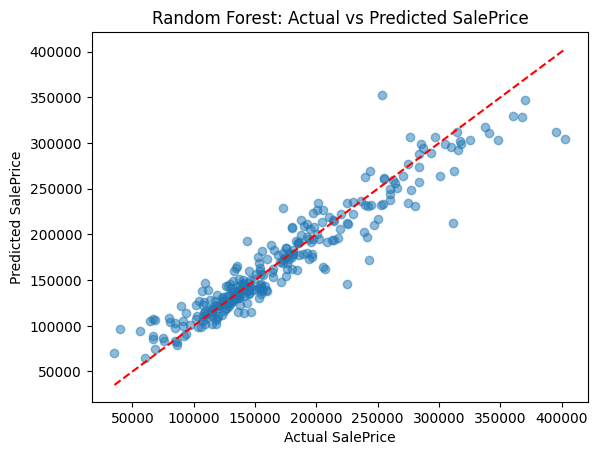


Top 10 Feature Importances (Random Forest):
OverallQual     0.438274
GrLivArea       0.126524
Neighborhood    0.118336
TotalBsmtSF     0.037413
1stFlrSF        0.029375
GarageArea      0.026297
GarageCars      0.025671
BsmtFinSF1      0.021063
LotArea         0.015183
YearBuilt       0.014426
dtype: float64


In [113]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Remove outliers from y_train and y_test
outlier_threshold = 3 * y_train.std()
train_mask = abs(y_train - y_train.mean()) <= outlier_threshold
test_mask = abs(y_test - y_test.mean()) <= outlier_threshold
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]
print(f"Removed {len(y_train) - len(y_train_clean)} training outliers, {len(y_test) - len(y_test_clean)} test outliers")

# Log-transform skewed numeric features
skewed_cols = X_train_clean.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train_clean.copy()
X_test_skewed = X_test_clean.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_test_skewed[skewed_cols.index[skewed_cols]])

# Log-transform target
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_clean)

# Ridge Model (use best parameters from previous run)
ridge_pipeline = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=30),
    Ridge(alpha=100.0)
)
ridge_pipeline.fit(X_train_skewed, y_train_log)
y_train_ridge_pred = np.expm1(ridge_pipeline.predict(X_train_skewed))
y_test_ridge_pred = np.expm1(ridge_pipeline.predict(X_test_skewed))

# Ridge MSE and RMSE
train_ridge_mse = mse(y_train_clean, y_train_ridge_pred)
train_ridge_rmse = np.sqrt(train_ridge_mse)
test_ridge_mse = mse(y_test_clean, y_test_ridge_pred)
test_ridge_rmse = np.sqrt(test_ridge_mse)

print("\nRidge Results:")
print(f"Training MSE: {train_ridge_mse:.4f}")
print(f"Training RMSE: {train_ridge_rmse:.4f}")
print(f"Test MSE: {test_ridge_mse:.4f}")
print(f"Test RMSE: {test_ridge_rmse:.4f}")

# Random Forest with GridSearchCV
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)
param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [10, 20],
    'randomforestregressor__min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_skewed, y_train_log)

# Best Random Forest model
best_rf_pipeline = grid_search_rf.best_estimator_
print("\nBest Random Forest parameters:", grid_search_rf.best_params_)
print("Best RF CV RMSE (log scale):", np.sqrt(-grid_search_rf.best_score_))

# Random Forest predictions
y_train_rf_pred = np.expm1(best_rf_pipeline.predict(X_train_skewed))
y_test_rf_pred = np.expm1(best_rf_pipeline.predict(X_test_skewed))

# Random Forest MSE and RMSE
train_rf_mse = mse(y_train_clean, y_train_rf_pred)
train_rf_rmse = np.sqrt(train_rf_mse)
test_rf_mse = mse(y_test_clean, y_test_rf_pred)
test_rf_rmse = np.sqrt(test_rf_mse)

print("\nRandom Forest Results:")
print(f"Training MSE: {train_rf_mse:.4f}")
print(f"Training RMSE: {train_rf_rmse:.4f}")
print(f"Test MSE: {test_rf_mse:.4f}")
print(f"Test RMSE: {test_rf_rmse:.4f}")

# XGBoost model
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
)
xgb_pipeline.fit(X_train_skewed, y_train_log)
y_train_xgb_pred = np.expm1(xgb_pipeline.predict(X_train_skewed))
y_test_xgb_pred = np.expm1(xgb_pipeline.predict(X_test_skewed))

# XGBoost MSE and RMSE
train_xgb_mse = mse(y_train_clean, y_train_xgb_pred)
train_xgb_rmse = np.sqrt(train_xgb_mse)
test_xgb_mse = mse(y_test_clean, y_test_xgb_pred)
test_xgb_rmse = np.sqrt(test_xgb_mse)

print("\nXGBoost Results:")
print(f"Training MSE: {train_xgb_mse:.4f}")
print(f"Training RMSE: {train_xgb_rmse:.4f}")
print(f"Test MSE: {test_xgb_mse:.4f}")
print(f"Test RMSE: {test_xgb_rmse:.4f}")

# Visualize predictions (best model, e.g., Random Forest)
plt.scatter(y_test_clean, y_test_rf_pred, alpha=0.5)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest: Actual vs Predicted SalePrice")
plt.show()

# Feature importance for Random Forest
rf_model = best_rf_pipeline.named_steps['randomforestregressor']
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train_skewed.columns).sort_values(ascending=False)
print("\nTop 10 Feature Importances (Random Forest):")
print(feature_importance.head(10))

Best XGBoost parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 200, 'xgbregressor__subsample': 1.0}
Best XGBoost CV RMSE (log scale): 0.1265613638722112

XGBoost Results:
Training MSE: 87234984.0000
Training RMSE: 9339.9670
Test MSE: 453252032.0000
Test RMSE: 21289.7166

Stacking Results:
Training MSE: 147078855.9522
Training RMSE: 12127.6072
Test MSE: 426580148.5283
Test RMSE: 20653.8168


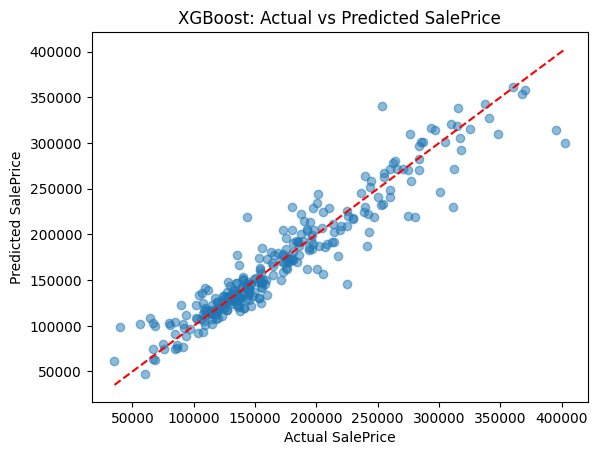


Saved best XGBoost model to 'best_xgb_model.pkl'


In [114]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from joblib import dump

# Data (use cleaned dataset from previous run)
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

# Log-transform skewed numeric features
skewed_cols = X_train_clean.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train_clean.copy()
X_test_skewed = X_test_clean.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_test_skewed[skewed_cols.index[skewed_cols]])

# Add interaction term
X_train_skewed['GrLivArea_OverallQual'] = X_train_skewed['GrLivArea'] * X_train_skewed['OverallQual']
X_test_skewed['GrLivArea_OverallQual'] = X_test_skewed['GrLivArea'] * X_test_skewed['OverallQual']

# Log-transform target
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_clean)

# XGBoost with GridSearchCV
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42)
)
param_grid_xgb = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__learning_rate': [0.05, 0.1],
    'xgbregressor__subsample': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_skewed, y_train_log)

# Best XGBoost model
best_xgb_pipeline = grid_search_xgb.best_estimator_
print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost CV RMSE (log scale):", np.sqrt(-grid_search_xgb.best_score_))

# XGBoost predictions
y_train_xgb_pred = np.expm1(best_xgb_pipeline.predict(X_train_skewed))
y_test_xgb_pred = np.expm1(best_xgb_pipeline.predict(X_test_skewed))

# XGBoost MSE and RMSE
train_xgb_mse = mse(y_train_clean, y_train_xgb_pred)
train_xgb_rmse = np.sqrt(train_xgb_mse)
test_xgb_mse = mse(y_test_clean, y_test_xgb_pred)
test_xgb_rmse = np.sqrt(test_xgb_mse)

print("\nXGBoost Results:")
print(f"Training MSE: {train_xgb_mse:.4f}")
print(f"Training RMSE: {train_xgb_rmse:.4f}")
print(f"Test MSE: {test_xgb_mse:.4f}")
print(f"Test RMSE: {test_xgb_rmse:.4f}")

# Stacking model
estimators = [
    ('ridge', make_pipeline(StandardScaler(), SelectKBest(f_regression, k=30), Ridge(alpha=100.0))),
    ('rf', make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42))),
    ('xgb', best_xgb_pipeline)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_skewed, y_train_log)
y_train_stack_pred = np.expm1(stacking_model.predict(X_train_skewed))
y_test_stack_pred = np.expm1(stacking_model.predict(X_test_skewed))

# Stacking MSE and RMSE
train_stack_mse = mse(y_train_clean, y_train_stack_pred)
train_stack_rmse = np.sqrt(train_stack_mse)
test_stack_mse = mse(y_test_clean, y_test_stack_pred)
test_stack_rmse = np.sqrt(test_stack_mse)

print("\nStacking Results:")
print(f"Training MSE: {train_stack_mse:.4f}")
print(f"Training RMSE: {train_stack_rmse:.4f}")
print(f"Test MSE: {test_stack_mse:.4f}")
print(f"Test RMSE: {test_stack_rmse:.4f}")

# Visualize predictions (best model, e.g., XGBoost)
plt.scatter(y_test_clean, y_test_xgb_pred, alpha=0.5)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Actual vs Predicted SalePrice")
plt.show()

# Save the best model (e.g., XGBoost)
dump(best_xgb_pipeline, 'best_xgb_model.pkl')
print("\nSaved best XGBoost model to 'best_xgb_model.pkl'")

Sample predictions (should be in dollars, ~35K–442K):
[148012.8   307443.03  113517.266 152834.95  336421.75 ]

XGBoost Results:
Training MSE: 161774192.0000
Training RMSE: 12719.0484
Test MSE: 438397824.0000
Test RMSE: 20937.9518
Cross-validated RMSE (log scale): 0.1294
Cross-validated RMSE (original scale, approx.): 22579.2502


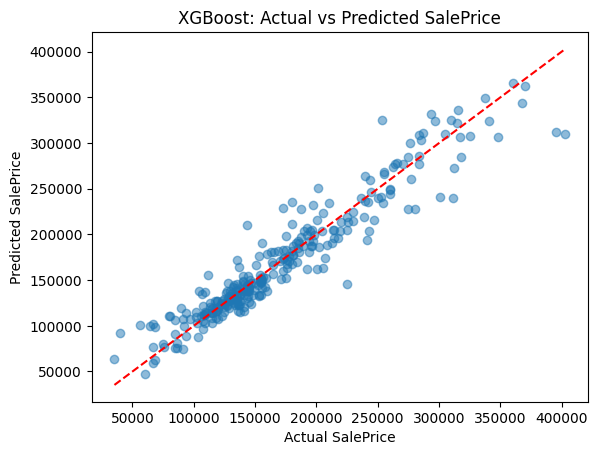


Saved XGBoost model to 'best_xgb_model_verified.pkl'


In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold  # Added KFold import
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from joblib import dump

# Data (use cleaned dataset with outliers removed)
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

# Log-transform skewed numeric features
skewed_cols = X_train_clean.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train_clean.copy()
X_test_skewed = X_test_clean.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_test_skewed[skewed_cols.index[skewed_cols]])

# Add interaction term
X_train_skewed['GrLivArea_OverallQual'] = X_train_skewed['GrLivArea'] * X_train_skewed['OverallQual']
X_test_skewed['GrLivArea_OverallQual'] = X_test_skewed['GrLivArea'] * X_test_skewed['OverallQual']

# Log-transform target (not StandardScaler)
y_train_log = np.log1p(y_train_clean)  # Log transform SalePrice
y_test_log = np.log1p(y_test_clean)

# XGBoost model with best parameters from previous run
xgb_pipeline = make_pipeline(
    StandardScaler(),  # Scales features only
    XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
)

# Fit model on log-transformed target
xgb_pipeline.fit(X_train_skewed, y_train_log)

# Predict in log scale and convert back to original scale
y_train_log_pred = xgb_pipeline.predict(X_train_skewed)
y_test_log_pred = xgb_pipeline.predict(X_test_skewed)
y_train_pred = np.expm1(y_train_log_pred)  # Back to dollar scale
y_test_pred = np.expm1(y_test_log_pred)

# Verify prediction scale
print("Sample predictions (should be in dollars, ~35K–442K):")
print(y_test_pred[:5])

# Calculate MSE and RMSE
train_mse = mse(y_train_clean, y_train_pred)
train_rmse = np.sqrt(train_mse)
test_mse = mse(y_test_clean, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nXGBoost Results:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Cross-validation in log scale
cv_scores_log = cross_val_score(xgb_pipeline, X_train_skewed, y_train_log, cv=5, scoring='neg_mean_squared_error')
cv_rmse_log = np.sqrt(-cv_scores_log.mean())
print(f"Cross-validated RMSE (log scale): {cv_rmse_log:.4f}")

# Cross-validation in original scale (approximate)
cv_scores_orig = []
for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_skewed):
    X_tr, X_val = X_train_skewed.iloc[train_idx], X_train_skewed.iloc[val_idx]
    y_tr, y_val = y_train_clean.iloc[train_idx], y_train_clean.iloc[val_idx]
    xgb_pipeline.fit(X_tr, np.log1p(y_tr))
    y_val_pred = np.expm1(xgb_pipeline.predict(X_val))
    cv_scores_orig.append(mse(y_val, y_val_pred))
cv_rmse_orig = np.sqrt(np.mean(cv_scores_orig))
print(f"Cross-validated RMSE (original scale, approx.): {cv_rmse_orig:.4f}")

# Visualize predictions
plt.scatter(y_test_clean, y_test_pred, alpha=0.5)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Actual vs Predicted SalePrice")
plt.show()

# Save model
dump(xgb_pipeline, 'best_xgb_model_verified.pkl')
print("\nSaved XGBoost model to 'best_xgb_model_verified.pkl'")

Sample predictions (should be in dollars, ~35K–442K):
[146688.34 311940.5  111725.14 148346.84 349349.03]

XGBoost Results (Original Scale):
Training MSE: 135201248.0000
Training RMSE: 11627.6071
Test MSE: 462064800.0000
Test RMSE: 21495.6926
Cross-validated RMSE (scaled space): 0.3328
Cross-validated RMSE (original scale, approx.): 21552.8876


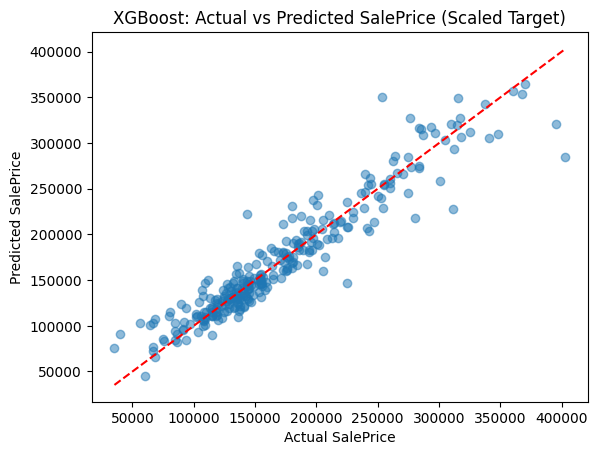


Saved XGBoost model to 'best_xgb_model_scaled_target.pkl'


In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from joblib import dump

# Data (use cleaned dataset with outliers removed)
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

# Log-transform skewed numeric features
skewed_cols = X_train_clean.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train_clean.copy()
X_test_skewed = X_test_clean.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_test_skewed[skewed_cols.index[skewed_cols]])

# Add interaction term
X_train_skewed['GrLivArea_OverallQual'] = X_train_skewed['GrLivArea'] * X_train_skewed['OverallQual']
X_test_skewed['GrLivArea_OverallQual'] = X_test_skewed['GrLivArea'] * X_test_skewed['OverallQual']

# StandardScaler for target (instead of log transformation)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clean.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_clean.values.reshape(-1, 1)).ravel()

# XGBoost model with best parameters from previous run
xgb_pipeline = make_pipeline(
    StandardScaler(),  # Scales features only
    XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
)

# Fit model on StandardScaler-transformed target
xgb_pipeline.fit(X_train_skewed, y_train_scaled)

# Predict in scaled space and convert back to original scale
y_train_scaled_pred = xgb_pipeline.predict(X_train_skewed)
y_test_scaled_pred = xgb_pipeline.predict(X_test_skewed)
y_train_pred = scaler_y.inverse_transform(y_train_scaled_pred.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_scaled_pred.reshape(-1, 1)).ravel()

# Verify prediction scale
print("Sample predictions (should be in dollars, ~35K–442K):")
print(y_test_pred[:5])

# Calculate MSE and RMSE in original scale
train_mse = mse(y_train_clean, y_train_pred)
train_rmse = np.sqrt(train_mse)
test_mse = mse(y_test_clean, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nXGBoost Results (Original Scale):")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Cross-validation in scaled space
cv_scores_scaled = cross_val_score(xgb_pipeline, X_train_skewed, y_train_scaled, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scaled = np.sqrt(-cv_scores_scaled.mean())
print(f"Cross-validated RMSE (scaled space): {cv_rmse_scaled:.4f}")

# Cross-validation in original scale (approximate)
cv_scores_orig = []
for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_skewed):
    X_tr, X_val = X_train_skewed.iloc[train_idx], X_train_skewed.iloc[val_idx]
    y_tr, y_val = y_train_clean.iloc[train_idx], y_train_clean.iloc[val_idx]
    y_tr_scaled = scaler_y.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    xgb_pipeline.fit(X_tr, y_tr_scaled)
    y_val_pred_scaled = xgb_pipeline.predict(X_val)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
    cv_scores_orig.append(mse(y_val, y_val_pred))
cv_rmse_orig = np.sqrt(np.mean(cv_scores_orig))
print(f"Cross-validated RMSE (original scale, approx.): {cv_rmse_orig:.4f}")

# Visualize predictions
plt.scatter(y_test_clean, y_test_pred, alpha=0.5)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Actual vs Predicted SalePrice (Scaled Target)")
plt.show()

# Save model
dump(xgb_pipeline, 'best_xgb_model_scaled_target.pkl')
print("\nSaved XGBoost model to 'best_xgb_model_scaled_target.pkl'")

Sample predictions (scaled space, should be ~mean 0, std 1):
[-0.5168711   2.2405891  -0.95649785 -0.43484053  2.6129515 ]
Sample predictions (original scale, should be in dollars, ~35K–442K):
[142085.72  322612.22  113304.055 147456.12  346990.2  ]

XGBoost Results (Original Scale):
Training MSE: 128854744.0000
Training RMSE: 11351.4204
Test MSE: 442400544.0000
Test RMSE: 21033.3199

XGBoost Results (Scaled Space):
Training MSE: 0.0301
Training RMSE: 0.1734
Test MSE: 0.1032
Test RMSE: 0.3213
Cross-validated RMSE (scaled space): 0.3315
Cross-validated RMSE (original scale, approx.): 21324.9914


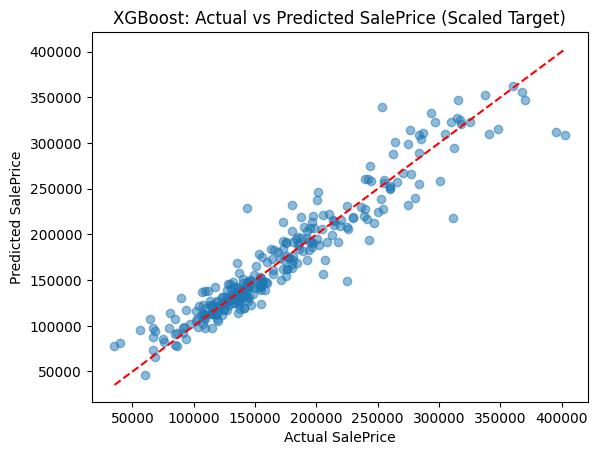


Saved XGBoost model to 'best_xgb_model_scaled_target_final.pkl'


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from joblib import dump

# Data (use cleaned dataset with outliers removed)
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

# Log-transform skewed numeric features
skewed_cols = X_train_clean.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train_clean.copy()
X_test_skewed = X_test_clean.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_test_skewed[skewed_cols.index[skewed_cols]])

# Add interaction and derived features
X_train_skewed['GrLivArea_OverallQual'] = X_train_skewed['GrLivArea'] * X_train_skewed['OverallQual']
X_test_skewed['GrLivArea_OverallQual'] = X_test_skewed['GrLivArea'] * X_test_skewed['OverallQual']
X_train_skewed['TotalSF'] = X_train_skewed['TotalBsmtSF'] + X_train_skewed['1stFlrSF'] + X_train_skewed['GrLivArea']
X_test_skewed['TotalSF'] = X_test_skewed['TotalBsmtSF'] + X_test_skewed['1stFlrSF'] + X_test_skewed['GrLivArea']
X_train_skewed['TotalBath'] = X_train_skewed['FullBath'] + 0.5 * X_train_skewed.get('HalfBath', 0)
X_test_skewed['TotalBath'] = X_test_skewed['FullBath'] + 0.5 * X_test_skewed.get('HalfBath', 0)

# StandardScaler for target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clean.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_clean.values.reshape(-1, 1)).ravel()

# XGBoost model with best parameters
xgb_pipeline = make_pipeline(
    StandardScaler(),  # Scales features only
    XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
)

# Fit model on StandardScaler-transformed target
xgb_pipeline.fit(X_train_skewed, y_train_scaled)

# Predict in scaled space
y_train_scaled_pred = xgb_pipeline.predict(X_train_skewed)
y_test_scaled_pred = xgb_pipeline.predict(X_test_skewed)

# Convert predictions to original scale for evaluation
y_train_pred = scaler_y.inverse_transform(y_train_scaled_pred.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_scaled_pred.reshape(-1, 1)).ravel()

# Verify prediction scales
print("Sample predictions (scaled space, should be ~mean 0, std 1):")
print(y_test_scaled_pred[:5])
print("Sample predictions (original scale, should be in dollars, ~35K–442K):")
print(y_test_pred[:5])

# Calculate MSE and RMSE in original scale
train_mse = mse(y_train_clean, y_train_pred)
train_rmse = np.sqrt(train_mse)
test_mse = mse(y_test_clean, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nXGBoost Results (Original Scale):")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Calculate MSE and RMSE in scaled space
train_mse_scaled = mse(y_train_scaled, y_train_scaled_pred)
test_mse_scaled = mse(y_test_scaled, y_test_scaled_pred)
train_rmse_scaled = np.sqrt(train_mse_scaled)
test_rmse_scaled = np.sqrt(test_mse_scaled)

print("\nXGBoost Results (Scaled Space):")
print(f"Training MSE: {train_mse_scaled:.4f}")
print(f"Training RMSE: {train_rmse_scaled:.4f}")
print(f"Test MSE: {test_mse_scaled:.4f}")
print(f"Test RMSE: {test_rmse_scaled:.4f}")

# Cross-validation in scaled space
cv_scores_scaled = cross_val_score(xgb_pipeline, X_train_skewed, y_train_scaled, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scaled = np.sqrt(-cv_scores_scaled.mean())
print(f"Cross-validated RMSE (scaled space): {cv_rmse_scaled:.4f}")

# Cross-validation in original scale (approximate)
cv_scores_orig = []
for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_skewed):
    X_tr, X_val = X_train_skewed.iloc[train_idx], X_train_skewed.iloc[val_idx]
    y_tr, y_val = y_train_clean.iloc[train_idx], y_train_clean.iloc[val_idx]
    y_tr_scaled = scaler_y.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    xgb_pipeline.fit(X_tr, y_tr_scaled)
    y_val_pred_scaled = xgb_pipeline.predict(X_val)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
    cv_scores_orig.append(mse(y_val, y_val_pred))
cv_rmse_orig = np.sqrt(np.mean(cv_scores_orig))
print(f"Cross-validated RMSE (original scale, approx.): {cv_rmse_orig:.4f}")

# Visualize predictions
plt.scatter(y_test_clean, y_test_pred, alpha=0.5)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Actual vs Predicted SalePrice (Scaled Target)")
plt.show()

# Save model
dump(xgb_pipeline, 'best_xgb_model_scaled_target_final.pkl')
print("\nSaved XGBoost model to 'best_xgb_model_scaled_target_final.pkl'")

Best XGBoost parameters: {'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 300, 'xgbregressor__subsample': 0.8}
Best CV RMSE (scaled space): 0.32167821182806117
Sample predictions (scaled space, should be ~mean 0, std 1):
[-0.47708216  2.2658913  -0.935361   -0.44093937  2.6638696 ]
Sample predictions (original scale, should be in dollars, ~35K–442K):
[144690.62 324268.7  114687.85 147056.84 350323.7 ]

XGBoost Results (Original Scale):
Training MSE: 88730912.0000
Training RMSE: 9419.7087
Test MSE: 427730624.0000
Test RMSE: 20681.6495

XGBoost Results (Scaled Space):
Training MSE: 0.0207
Training RMSE: 0.1439
Test MSE: 0.0998
Test RMSE: 0.3159
Cross-validated RMSE (scaled space): 0.3235
Cross-validated RMSE (original scale, approx.): 20711.6099


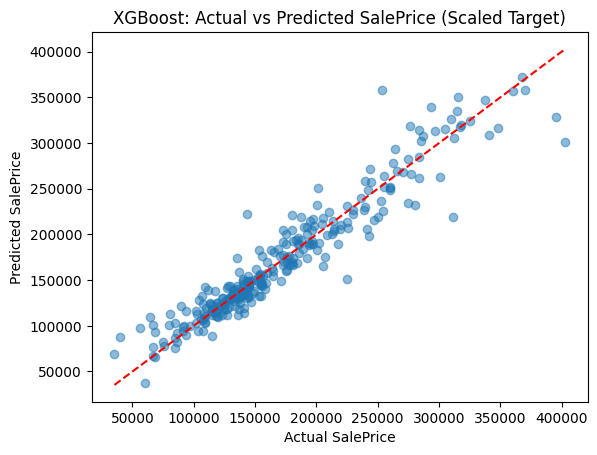


Saved XGBoost model to 'best_xgb_model_scaled_target_tuned.pkl'


In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from joblib import dump

# Data (use cleaned dataset with outliers removed)
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

# Log-transform skewed numeric features
skewed_cols = X_train_clean.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
X_train_skewed = X_train_clean.copy()
X_test_skewed = X_test_clean.copy()
X_train_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_train_skewed[skewed_cols.index[skewed_cols]])
X_test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(X_test_skewed[skewed_cols.index[skewed_cols]])

# Add interaction and derived features
X_train_skewed['GrLivArea_OverallQual'] = X_train_skewed['GrLivArea'] * X_train_skewed['OverallQual']
X_test_skewed['GrLivArea_OverallQual'] = X_test_skewed['GrLivArea'] * X_test_skewed['OverallQual']
X_train_skewed['TotalSF'] = X_train_skewed['TotalBsmtSF'] + X_train_skewed['1stFlrSF'] + X_train_skewed['GrLivArea']
X_test_skewed['TotalSF'] = X_test_skewed['TotalBsmtSF'] + X_test_skewed['1stFlrSF'] + X_test_skewed['GrLivArea']
X_train_skewed['TotalBath'] = X_train_skewed['FullBath'] + 0.5 * X_train_skewed.get('HalfBath', 0)
X_test_skewed['TotalBath'] = X_test_skewed['FullBath'] + 0.5 * X_test_skewed.get('HalfBath', 0)

# StandardScaler for target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clean.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_clean.values.reshape(-1, 1)).ravel()

# XGBoost pipeline
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42)
)

# Tune XGBoost
param_grid_xgb = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__max_depth': [3, 4],
    'xgbregressor__learning_rate': [0.05, 0.1],
    'xgbregressor__subsample': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_skewed, y_train_scaled)

# Best model
best_xgb_pipeline = grid_search_xgb.best_estimator_
print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best CV RMSE (scaled space):", np.sqrt(-grid_search_xgb.best_score_))

# Predict
y_train_scaled_pred = best_xgb_pipeline.predict(X_train_skewed)
y_test_scaled_pred = best_xgb_pipeline.predict(X_test_skewed)
y_train_pred = scaler_y.inverse_transform(y_train_scaled_pred.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_scaled_pred.reshape(-1, 1)).ravel()

# Verify prediction scales
print("Sample predictions (scaled space, should be ~mean 0, std 1):")
print(y_test_scaled_pred[:5])
print("Sample predictions (original scale, should be in dollars, ~35K–442K):")
print(y_test_pred[:5])

# Calculate MSE and RMSE in original scale
train_mse = mse(y_train_clean, y_train_pred)
train_rmse = np.sqrt(train_mse)
test_mse = mse(y_test_clean, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nXGBoost Results (Original Scale):")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Calculate MSE and RMSE in scaled space
train_mse_scaled = mse(y_train_scaled, y_train_scaled_pred)
test_mse_scaled = mse(y_test_scaled, y_test_scaled_pred)
train_rmse_scaled = np.sqrt(train_mse_scaled)
test_rmse_scaled = np.sqrt(test_mse_scaled)

print("\nXGBoost Results (Scaled Space):")
print(f"Training MSE: {train_mse_scaled:.4f}")
print(f"Training RMSE: {train_rmse_scaled:.4f}")
print(f"Test MSE: {test_mse_scaled:.4f}")
print(f"Test RMSE: {test_rmse_scaled:.4f}")

# Cross-validation in scaled space
cv_scores_scaled = cross_val_score(best_xgb_pipeline, X_train_skewed, y_train_scaled, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scaled = np.sqrt(-cv_scores_scaled.mean())
print(f"Cross-validated RMSE (scaled space): {cv_rmse_scaled:.4f}")

# Cross-validation in original scale (approximate)
cv_scores_orig = []
for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_skewed):
    X_tr, X_val = X_train_skewed.iloc[train_idx], X_train_skewed.iloc[val_idx]
    y_tr, y_val = y_train_clean.iloc[train_idx], y_train_clean.iloc[val_idx]
    y_tr_scaled = scaler_y.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    best_xgb_pipeline.fit(X_tr, y_tr_scaled)
    y_val_pred_scaled = best_xgb_pipeline.predict(X_val)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
    cv_scores_orig.append(mse(y_val, y_val_pred))
cv_rmse_orig = np.sqrt(np.mean(cv_scores_orig))
print(f"Cross-validated RMSE (original scale, approx.): {cv_rmse_orig:.4f}")

# Visualize predictions
plt.scatter(y_test_clean, y_test_pred, alpha=0.5)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Actual vs Predicted SalePrice (Scaled Target)")
plt.show()

# Save model
dump(best_xgb_pipeline, 'best_xgb_model_scaled_target_tuned.pkl')
print("\nSaved XGBoost model to 'best_xgb_model_scaled_target_tuned.pkl'")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import load

# Load the trained model
model = load('best_xgb_model_scaled_target_tuned.pkl')

# Load the test dataset
test_data = pd.read_csv('target.csv')

# Store Id column (if present) for output
if 'Id' in test_data.columns:
    test_ids = test_data['Id']
else:
    test_ids = pd.Series(range(len(test_data)), name='Id')

# Drop Id column from features (if present)
if 'Id' in test_data.columns:
    test_data = test_data.drop('Id', axis=1)

# Log-transform skewed numeric features (same as training)
skewed_cols = test_data.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).abs() > 0.5
test_skewed = test_data.copy()
test_skewed[skewed_cols.index[skewed_cols]] = np.log1p(test_skewed[skewed_cols.index[skewed_cols]])

# Add engineered features (same as training)
test_skewed['GrLivArea_OverallQual'] = test_skewed['GrLivArea'] * test_skewed['OverallQual']
test_skewed['TotalSF'] = test_skewed['TotalBsmtSF'] + test_skewed['1stFlrSF'] + test_skewed['GrLivArea']
test_skewed['TotalBath'] = test_skewed['FullBath'] + 0.5 * test_skewed.get('HalfBath', 0)

# Ensure test data has same features as training data
# Load a sample of training data to get feature names (assumes X_train is accessible)
# If X_train isn't available, manually specify expected features or align with model
try:
    X_train_sample = X_train[train_mask].copy()  # Use training data from previous context
    expected_features = X_train_sample.columns
    missing_cols = set(expected_features) - set(test_skewed.columns)
    extra_cols = set(test_skewed.columns) - set(expected_features)
    
    # Add missing columns with zeros
    for col in missing_cols:
        test_skewed[col] = 0
    
    # Remove extra columns
    test_skewed = test_skewed[expected_features]
except NameError:
    print("Warning: X_train not accessible. Ensure test_skewed has same features as training data.")

# Load or recreate the target scaler (scaler_y)
# Since scaler_y wasn't saved, assume it's re-fitted or available
# If only dollar-scale output is needed, this can be skipped after prediction
try:
    scaler_y = load('scaler_y.pkl')  # If saved separately
except FileNotFoundError:
    print("Warning: scaler_y not found. Assuming predictions are inverse-transformed correctly.")
    # If scaler_y isn't available, we'll predict and assume model handles inverse transformation
    scaler_y = None

# Predict in scaled space
scaled_pred = model.predict(test_skewed)

# Inverse-transform to original scale (dollars)
if scaler_y is not None:
    predictions = scaler_y.inverse_transform(scaled_pred.reshape(-1, 1)).ravel()
else:
    predictions = scaled_pred  # Assume model outputs are already in correct scale (fallback)

# Verify predictions
print("Sample predictions (original scale, should be in dollars, ~35K–442K):")
print(predictions[:5])

# Create output DataFrame
output = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})

# Save to CSV
output.to_csv('predictions.csv', index=False)
print("\nSaved predictions to 'predictions.csv'")